# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from pandas import DataFrame
from matplotlib.pyplot import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import socket
import data_exploration
import unsupervised_ML
#_ = importlib.reload(data_exploration)
#_ = importlib.reload(unsupervised_ML)
%matplotlib inline

# UNCONSTRAINED DISPLAY
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))
np.set_printoptions(linewidth=400)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
InteractiveShell.ast_node_interactivity = "all"
FIG_WIDTH = 18
FIG_HEIGHT = 8
LABEL_SIZE = 20
TICKS_SIZE = 16
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data
- **Retrieve Data**
- **Explore Missing Data**
- **Handle Missing Column Data**
- **Preprocess Features**
- **Impute Missing Data**
- **Handle Outliers**
- **Compare Datasets**

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

<br/>

## Retrieve Data

In [2]:
# RETRIEVE DATA
# --- Local copies ---
genpop = pd.read_csv("Udacity_AZDIAS_052018.csv", index_col=[0])
kunden = pd.read_csv("Udacity_CUSTOMERS_052018.csv", index_col=[0])
mailed = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv", index_col=[0])
totest = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv", index_col=[0])

In [3]:
print("General Population % data missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Customer % data missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

General Population % data missing: 10%
Customer % data missing: 20%


<br/><br/>

## Explore Missing Data
The distribution of missing data shown below, exhibits a surprising deterioration with jumps. This seems to indicate that two or more separate data collection efforts have been used and mixed to produce our data. It may be the result of separate survey questionnaires, different data collection agencies, or some similar reason. We have a listwise deletion vs imputation trade-off. Given our suspicion that the data was sourced from multiple collection efforts, we don't want to throw away anything, lest we discard the data most pertinent to customers, from a more recent and more focused customer survey, say. 

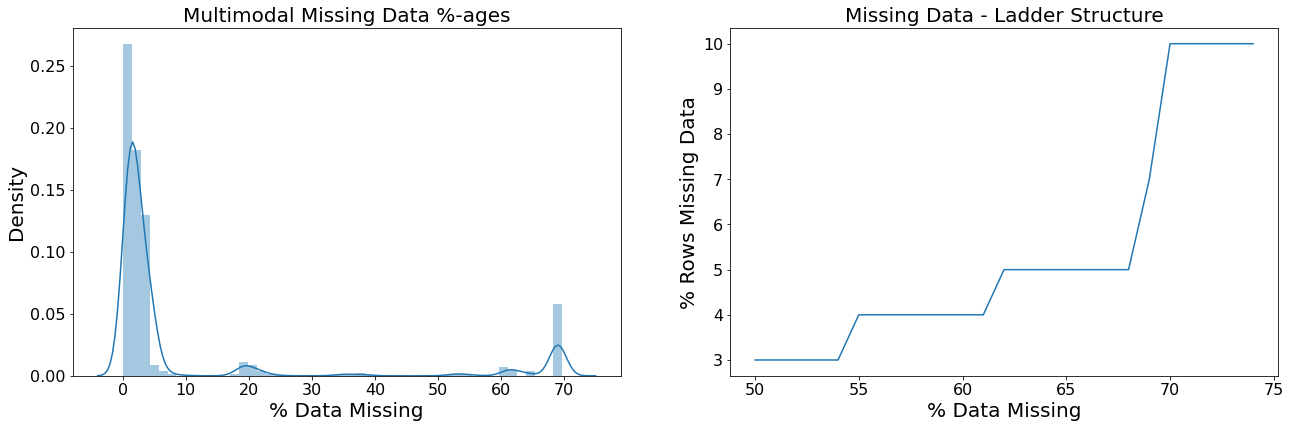

In [4]:
data_exploration.missing_data(genpop)

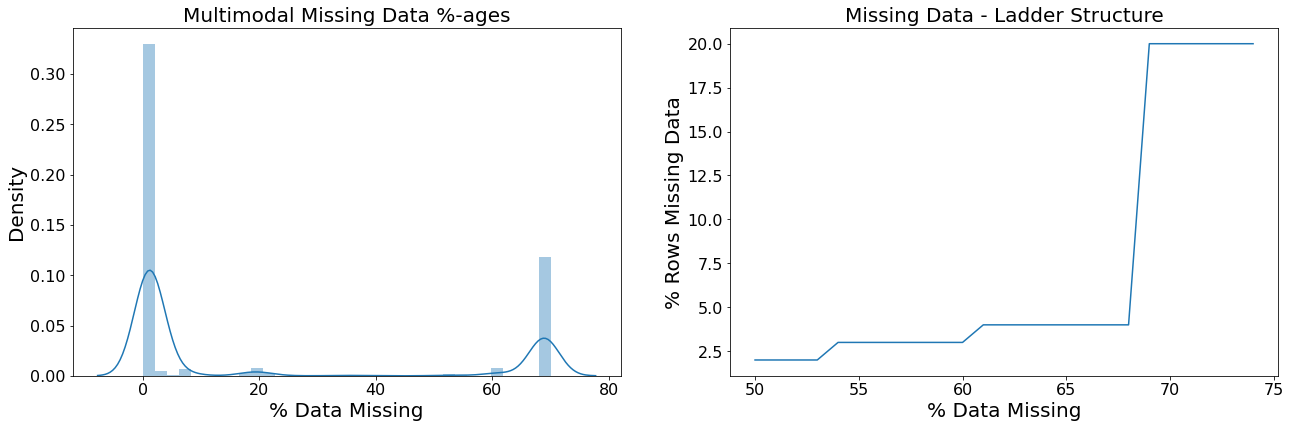

In [5]:
data_exploration.missing_data(kunden)

In [6]:
genpop.head()
print("----- Types & Obj cols. ------")
genpop.describe(include=['object'])

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

----- Types & Obj cols. ------


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


<br/>

## Handle Missing Column Data
- **Drop Columns:** Dropping columns loses more than the information in them. It throws away the relation of the discarded values with neighboring features. Dropping features is something best done later when we perform Principal Component Analysis; there the features are traded-off against retained variance, and hence, such choices are justifiable. We'll restrict the dropping of features to those that are irrelevant to analysis, or those that are missing so much data that their usefulness is questionable. The function **`dropoff()`** eliminates columns missing data in excess of a `cutoff` value at `30%`. This arbitrary level is based on inspecting the percentages of missing data by columns. The code cell below shows these percentages; notice the large jump in missing feature data starting at 30% for both datasets; also notice that very few columns exceed this cutoff level, making the 30% a benign choice for data integrity.

- **Irrelevant Columns:** In `EINGEFUEGT_AM` (German for `inserted at`), we have a date-time feature. This is a good candidate to drop, together with the ID column `LNR`; these features add nothing to the analysis.

- **Extraneous Columns:** The customer dataset contains three excess columns `CUSTOMER_GROUP`, `ONLINE_PURCHASE`, and `PRODUCT_GROUP`, which need to be dropped as they are particular to the customer dataset, but not to the general population. The general population and customer datasets are going to be put through unsupervised ML techniques that expect their features to be the same.

In [7]:
print("----- General Population - High Offending Columns ------")
round(100*genpop.isnull().mean(),2).sort_values(ascending=False).head(10)
print("---------- Customers - High Offending Columns ----------")
round(100*kunden.isnull().mean(),2).sort_values(ascending=False).head(10)

----- General Population - High Offending Columns ------


ALTER_KIND4                    99.86
ALTER_KIND3                    99.31
ALTER_KIND2                    96.69
ALTER_KIND1                    90.90
EXTSEL992                      73.40
KK_KUNDENTYP                   65.60
ALTERSKATEGORIE_FEIN           29.50
D19_VERSAND_ONLINE_QUOTE_12    28.85
D19_LOTTO                      28.85
D19_BANKEN_ONLINE_QUOTE_12     28.85
dtype: float64

---------- Customers - High Offending Columns ----------


ALTER_KIND4        99.88
ALTER_KIND3        99.33
ALTER_KIND2        97.34
ALTER_KIND1        93.86
KK_KUNDENTYP       58.41
EXTSEL992          44.50
KBA05_KRSOBER      29.21
KBA05_KRSHERST1    29.21
KBA05_GBZ          29.21
KBA05_HERST1       29.21
dtype: float64

In [8]:
# Drop columns with excess (>30%) missing data
print("----- General Population ------")
drop_genpop = data_exploration.dropoff(genpop, cutoff=.3)
genpop.drop(drop_genpop, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_genpop))
print("Percent of data still missing: {:>3}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("---------- Customers ----------")
drop_kunden = data_exploration.dropoff(kunden, cutoff=.3)
kunden.drop(drop_kunden, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_kunden))
print("Percent of data still missing: {:>3}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

----- General Population ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Percent of data still missing:   9%
---------- Customers ----------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Percent of data still missing:  19%


In [9]:
# Drop columns with no analytical value
genpop.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)
kunden.drop(['LNR', 'EINGEFUEGT_AM', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

<br/>

## Preprocess Features

In [10]:
genpop.describe(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,792242,792242,792242,634108,798073
unique,45,19,43,35,2
top,6B,8,51,D19_UNBEKANNT,W
freq,56672,78023,77576,195338,629528


In [11]:
# Uncomment each line to see why preprocessing is needed.
#genpop['CAMEO_DEU_2015'].value_counts()
#genpop['CAMEO_DEUG_2015'].value_counts()
#genpop['CAMEO_INTL_2015'].value_counts()
#genpop['D19_LETZTER_KAUF_BRANCHE'].value_counts()
#genpop['OST_WEST_KZ'].value_counts()

These five features need processing. Guidance from the EXCEL spreadsheet reveals they are a mixture of nominal and ordinal categories:
- **`CAMEO_DEU_2015 - Nominal`:** 44 clearly nominal ('Cottage Chick", 'Coffee Rider', 'Socking Away', and the like) slots with an extra "XX" slot as a catch-all default bin for unknowns.
- **`D19_LETZTER_KAUF_BRANCHE - Nominal`:** The name, _LETZTER_KAUF_BRANCHE_ appears to indicate the kind of article that was bought last, ranging in diversity from shoes, to books, to cosmetics, etc. This column contains other column names for its entries. 
- **`OST_WEST_KZ - Nominal (Binary)`:** A simple binary category for West and East German individuals.
- **`CAMEO_DEUG_2015 - Ordinal`:** A catch-all default bin "X" is present in this data; additionally, we have what appears to be phantom duplicate slots; there are rows in slot "1", as well as "1.0", similarly for "2" and "2.0", "3", and "3.0", and so on up to "9", and "9.0". Half of the slots are of string type, and the other half numerical. These entries need to be collated to a numerical category that disambiguates them.
- **`CAMEO_INTL_2015 - Ordinal`:** A catch-all default bin "XX" needs encoding as the last integer in the resulting numerical feature; additionally, we need to disambiguate phantom double categories by collating.

In the code cell below, we use the functions **`label_encode()`**, and **`disambiguate()`** to carry out the above mentoned steps.

The rest of the columns are already label encoded.

In [12]:
print("----- General Population - Preprocessing features ------")
data_exploration.label_encode(genpop, 'CAMEO_DEU_2015')
data_exploration.label_encode(genpop, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.label_encode(genpop, 'OST_WEST_KZ')
data_exploration.disambiguate(genpop, 'CAMEO_DEUG_2015', "X")
data_exploration.disambiguate(genpop, 'CAMEO_INTL_2015', "XX")
print("---------- Customers - Preprocessing features ----------")
data_exploration.label_encode(kunden, 'CAMEO_DEU_2015')
data_exploration.label_encode(kunden, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.label_encode(kunden, 'OST_WEST_KZ')
data_exploration.disambiguate(kunden, 'CAMEO_DEUG_2015', "X")
data_exploration.disambiguate(kunden, 'CAMEO_INTL_2015', "XX")

----- General Population - Preprocessing features ------
[CAMEO_DEU_2015                ](BEFORE) : [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C' 'XX']
   ( AFTER) : [nan 35. 15.  5. 25. 37. 13.  8.  0.  4. 42. 20. 36. 30. 21. 43. 40.  1. 12. 17. 14. 11. 18. 31. 39. 27. 28.  7. 32. 41. 33. 22.  3. 38. 26. 24. 19. 16.  9.  6. 34. 10. 29. 23.  2. 44.]
Mapping ==>> {0: '1A', 1: '1B', 2: '1C', 3: '1D', 4: '1E', 5: '2A', 6: '2B', 7: '2C', 8: '2D', 9: '3A', 10: '3B', 11: '3C', 12: '3D', 13: '4A', 14: '4B', 15: '4C', 16: '4D', 17: '4E', 18: '5A', 19: '5B', 20: '5C', 21: '5D', 22: '5E', 23: '5F', 24: '6A', 25: '6B', 26: '6C', 27: '6D', 28: '6E', 29: '6F', 30: '7A', 31: '7B', 32: '7C', 33: '7D', 34: '7E', 35: '8A', 36: '8B', 37: '8C', 38: '8D', 39: '9A', 40: '9B', 41: '9C', 42: '9D', 43: '9E', 44: 'XX'}
[D19_LETZTER_KA

<br/><br/>

## Impute Missing Values
There is plenty of literature on the subject of imputation, as well as tools available. One method known as Univariate Imputation consists of replacing the missing entries of a feature, using some function of its non-missing values without taking into account the relations that may exist with other features. We'll use a `Random Selection` univariate imputation method as suggested by `Quintero et al (2018)` which performs well with mostly ordinal data. This is a  method that preserves the distribution of the imputed feature. The functions **`impute()`**, and **`random_selection()`** implement our version of the this algorithm and impute over all the features of a given dataset.

In [13]:
data_exploration.impute(genpop) 

.........................................................................................................................................................................................................................................

In [14]:
data_exploration.impute(kunden)

...........................................................................................................................................................................................................................................

In [15]:
print("Population missing entries: {}".format(genpop.isnull().sum().sum()))
print("Customer missing entries:   {}".format(kunden.isnull().sum().sum()))

Population missing entries: 3345146
Customer missing entries:   1293743


We still have some missing data because the imputation algorithm skips binaries as well as features having more than 10 bins. This arbitrary range of bin counts is based on the observation that the great majority of features in the datasets happen to be ordinal with 10 or less slots. Features deviating from this pattern can be inspected with the function **`before_and_after()`**, which shows the effect of the imputation on a before and after basis, without actually performing it. The **before** picture shows the missing data as an arbitrary category of our creation, a fake NaNs bin with a chosen label value, say **“-10”**, for example, shown as a red bar side-by-side with the rest of the data. Next to it, the **after** picture depicts the “would-be” effect of imputing with the technique.

,ALTERSKATEGORIE_FEIN,D19_LETZTER_KAUF_BRANCHE,D19_GESAMT_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,HH_DELTA_FLAG,KBA13_ANZAHL_PKW,CAMEO_INTL_2015,CAMEO_DEU_2015,CAMEO_DEUG_2015,VERDICHTUNGSRAUM,ORTSGR_KLS9,ANZ_HH_TITEL,KONSUMZELLE,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,DSL_FLAG,VK_ZG11,VK_DHT4A,VK_DISTANZ,EINGEZOGENAM_HH_JAHR,ANZ_PERSONEN,UNGLEICHENN_FLAG,ALTER_HH,SOHO_KZ,ANZ_KINDER,LP_STATUS_FEIN,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,GFK_URLAUBERTYP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,15.0,4.0,10.0
1,21.0,NaN,NaN,NaN,NaN,0.0,963.0,51.0,35.0,8.0,0.0,5.0,0.0,1.0,11.0,12.0,1992.0,1.0,1.0,10.0,8.0,11.0,2004.0,2.0,1.0,0.0,1.0,0.0,2.0,5.0,21.0,6.0,10.0
2,17.0,30.0,0.0,0.0,0.0,0.0,712.0,24.0,15.0,4.0,1.0,5.0,0.0,0.0,10.0,7.0,1992.0,1.0,1.0,6.0,9.0,9.0,2000.0,1.0,0.0,17.0,0.0,0.0,3.0,1.0,3.0,1.0,10.0
3,13.0,30.0,0.0,0.0,0.0,NaN,596.0,12.0,5.0,2.0,0.0,3.0,0.0,0.0,1.0,2.0,1997.0,1.0,1.0,11.0,7.0,10.0,1998.0,0.0,0.0,13.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0
4,14.0,24.0,10.0,10.0,10.0,0.0,435.0,43.0,25.0,6.0,1.0,6.0,0.0,0.0,3.0,3.0,1992.0,1.0,1.0,4.0,3.0,5.0,2004.0,4.0,0.0,20.0,0.0,0.0,3.0,10.0,32.0,10.0,5.0


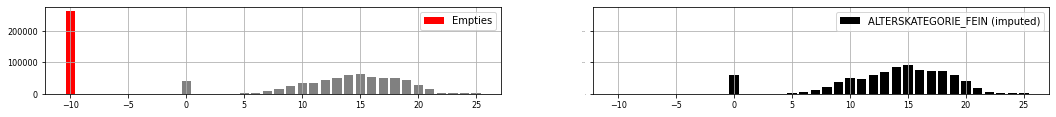

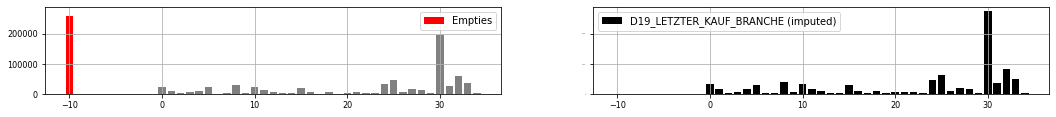

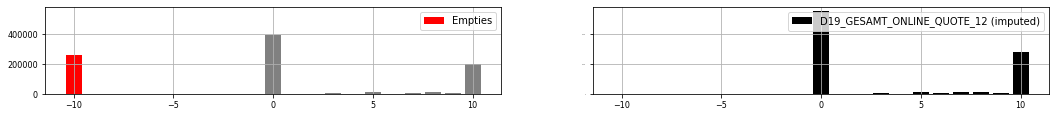

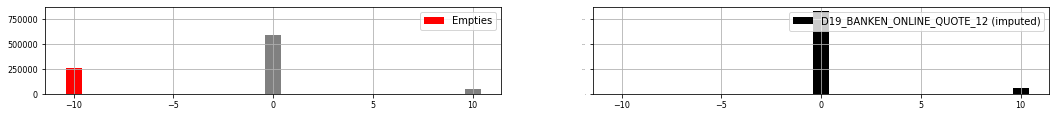

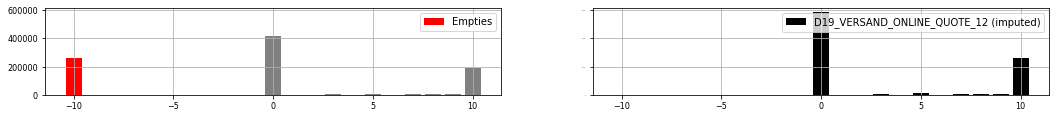

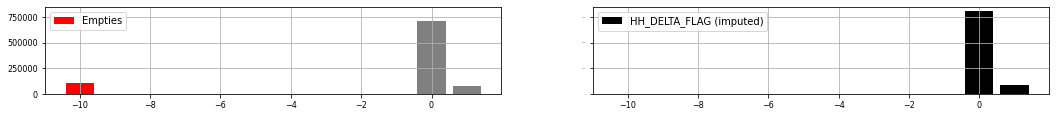

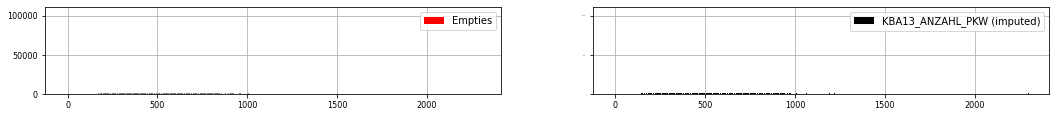

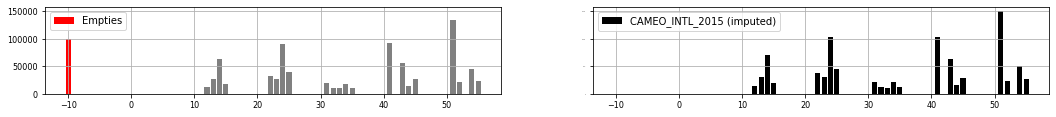

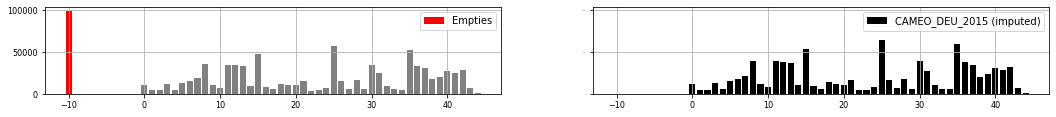

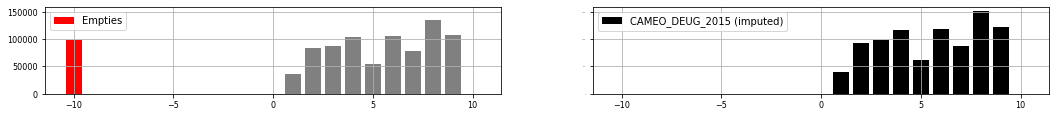

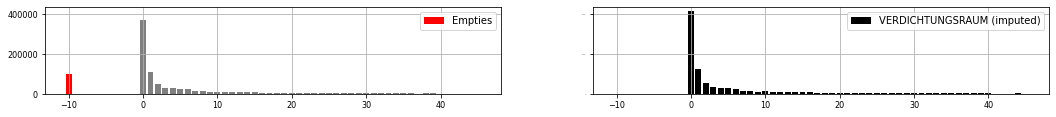

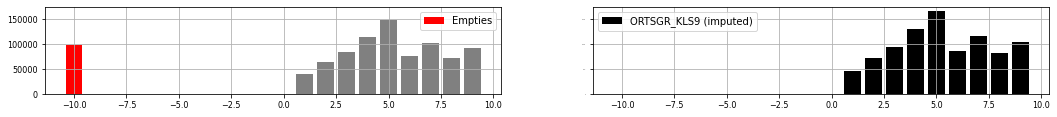

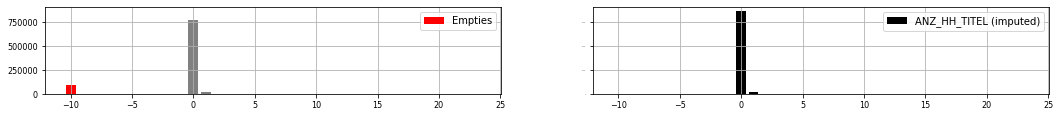

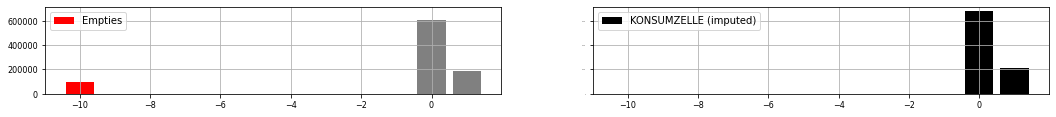

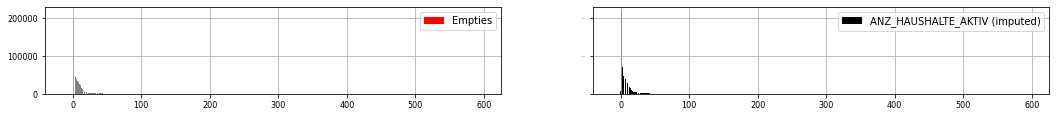

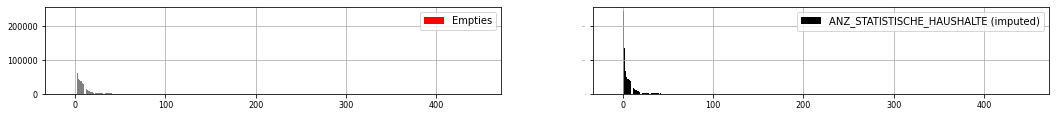

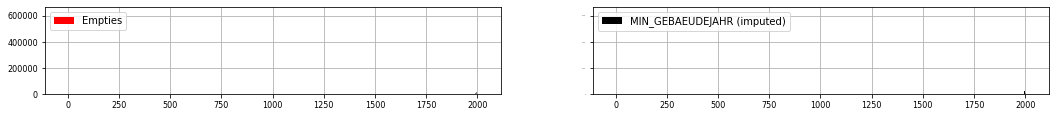

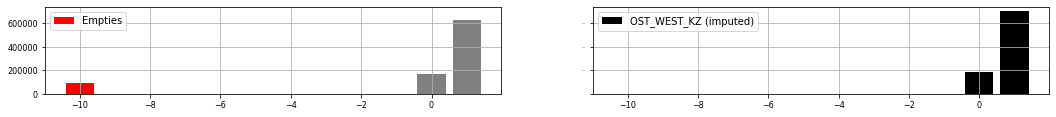

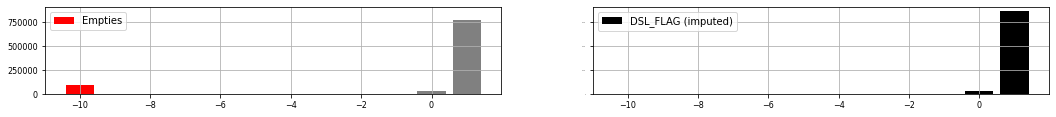

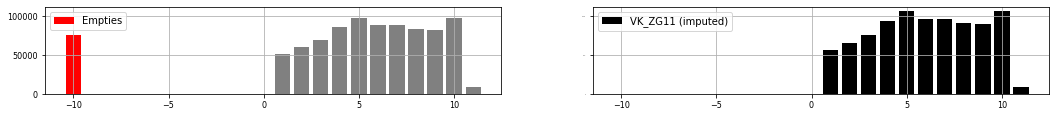

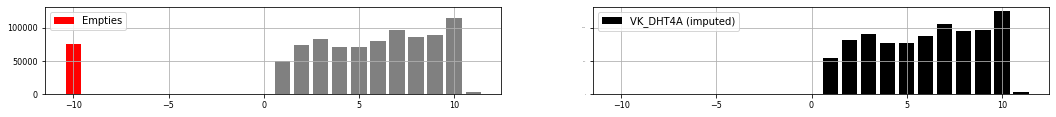

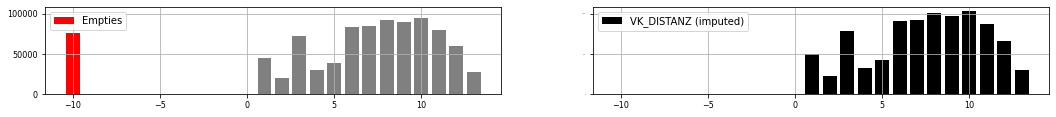

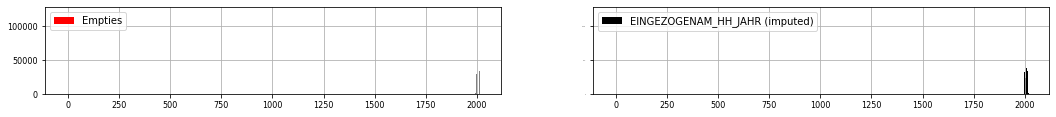

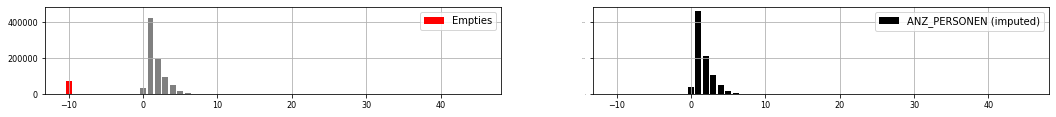

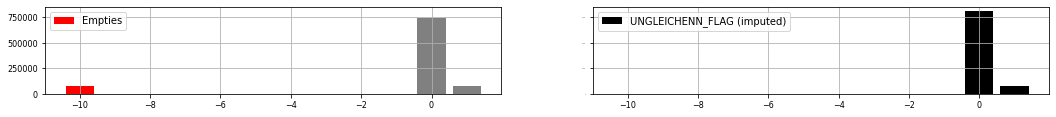

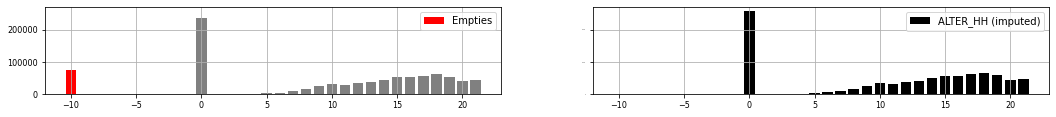

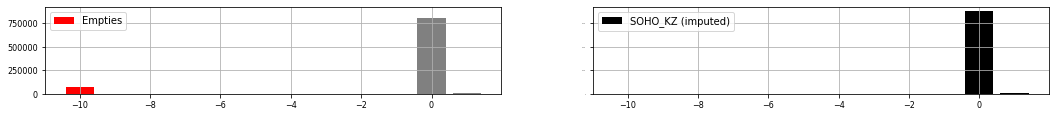

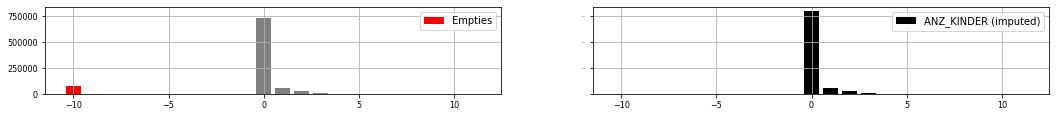

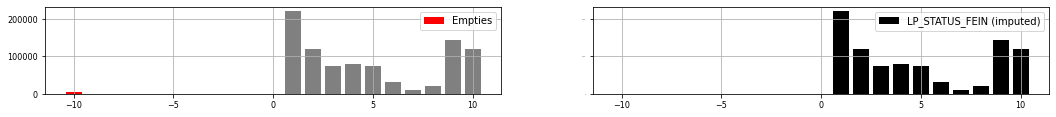

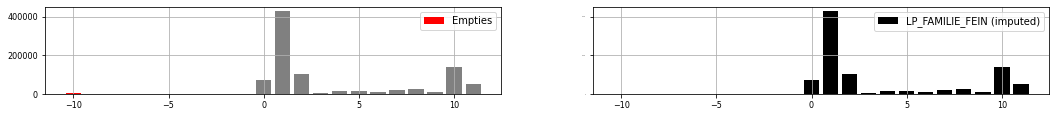

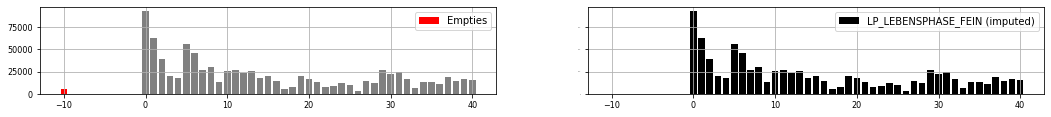

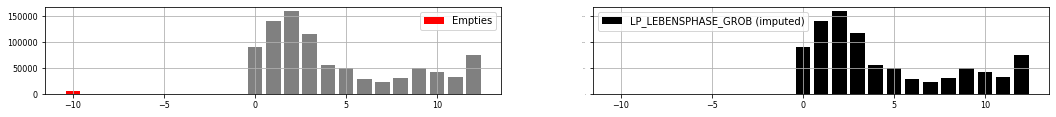

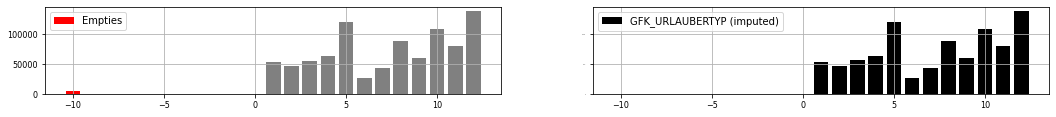

In [16]:
# Examine General Population missing data.
genpop_missing = genpop[genpop.isnull().mean().sort_values(ascending=False)[genpop.isnull().mean().sort_values(ascending=False) > 0].index[:]]
genpop_missing.head()
for feature in genpop_missing:
    data_exploration.before_and_after(genpop_missing[feature], feature, nanbin=-10, height=FIG_HEIGHT/5)

Except for the columns **'KBA13_ANZAHL_PKW, ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR'**, and **'EINGEZOGENAM_HH_JAHR'**, which require further examination, all others can be imputed.

In [17]:
# Remove columns from General Population missing list to prevent imputation.
genpop_missing.drop(['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR'], axis=1, inplace=True)

# Carryout imputations
for feature in genpop_missing:
    data_exploration.random_selection(genpop[feature])

,HH_DELTA_FLAG,ANZ_HH_TITEL,ALTERSKATEGORIE_FEIN,KBA13_ANZAHL_PKW,VERDICHTUNGSRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,DSL_FLAG,KONSUMZELLE,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,VK_ZG11,VK_DHT4A,VK_DISTANZ,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_LETZTER_KAUF_BRANCHE,D19_BANKEN_ONLINE_QUOTE_12,SOHO_KZ,EINGEZOGENAM_HH_JAHR,ANZ_PERSONEN,UNGLEICHENN_FLAG,ALTER_HH,GFK_URLAUBERTYP,LP_LEBENSPHASE_FEIN,LP_FAMILIE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN
0,0.0,0.0,10.0,1201.0,8.0,0.0,1.0,13.0,1.0,0.0,1.0,1.0,1992.0,1.0,2.0,5.0,3.0,0.0,0.0,30.0,0.0,0.0,1994.0,2.0,0.0,10.0,4.0,20.0,2.0,5.0,10.0
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6.0,6.0,0.0,0.0,1.0,0.0,0.0,2007.0,3.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,433.0,0.0,21.0,5.0,34.0,1.0,1.0,1.0,1.0,1992.0,1.0,11.0,10.0,13.0,0.0,0.0,30.0,0.0,0.0,1996.0,1.0,0.0,6.0,3.0,13.0,1.0,3.0,10.0
3,NaN,NaN,8.0,755.0,0.0,15.0,4.0,24.0,1.0,0.0,0.0,1.0,1992.0,1.0,2.0,6.0,4.0,0.0,0.0,20.0,0.0,0.0,1997.0,0.0,0.0,8.0,10.0,0.0,0.0,0.0,9.0
4,1.0,0.0,14.0,513.0,1.0,31.0,7.0,41.0,1.0,1.0,7.0,7.0,1992.0,1.0,4.0,3.0,5.0,10.0,10.0,24.0,0.0,0.0,1997.0,4.0,0.0,20.0,2.0,31.0,10.0,10.0,1.0


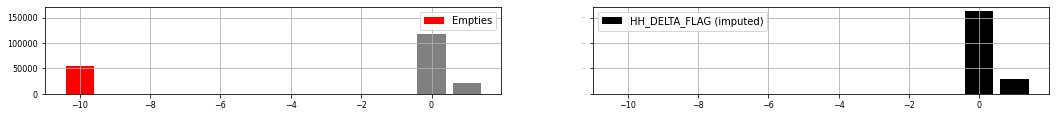

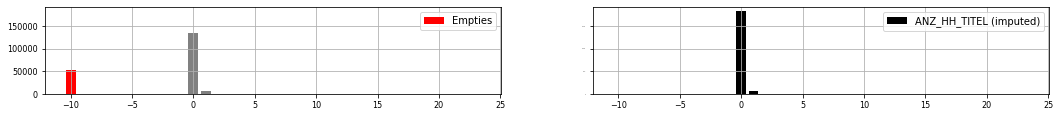

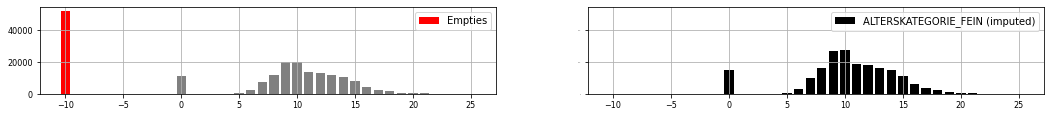

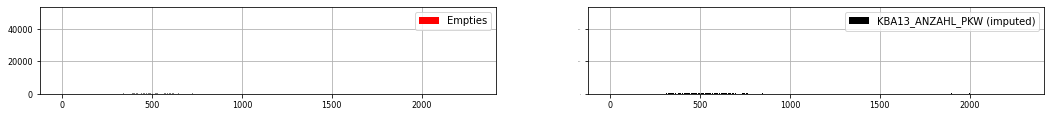

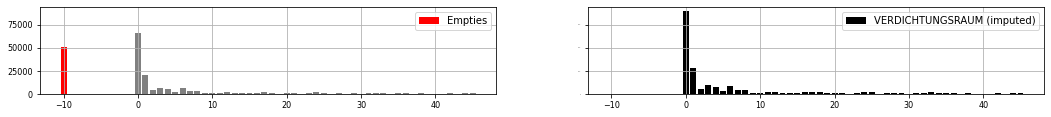

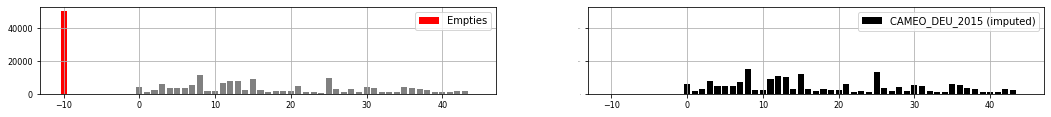

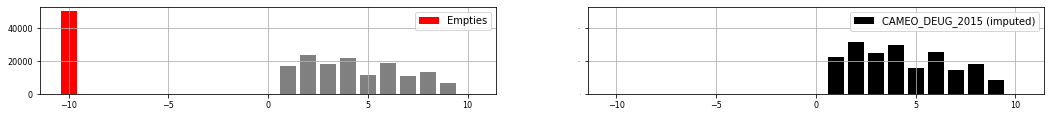

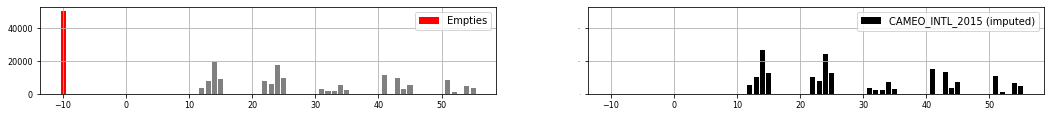

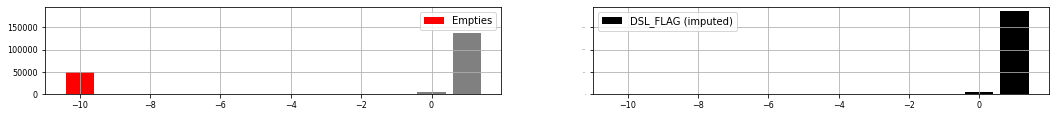

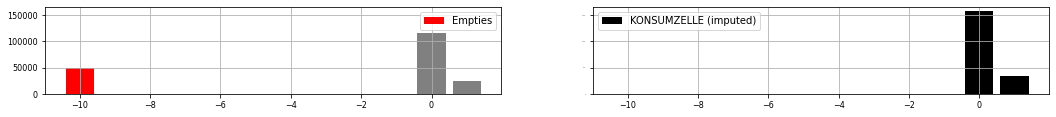

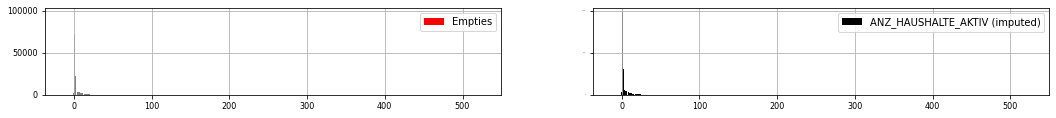

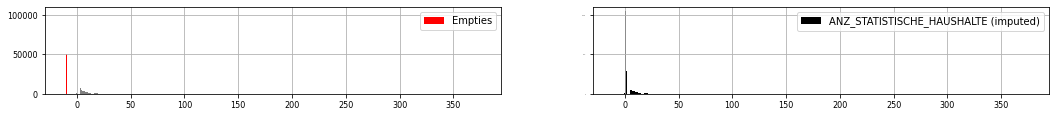

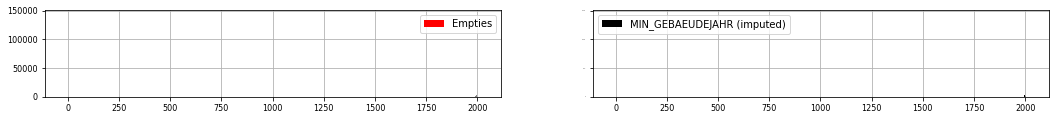

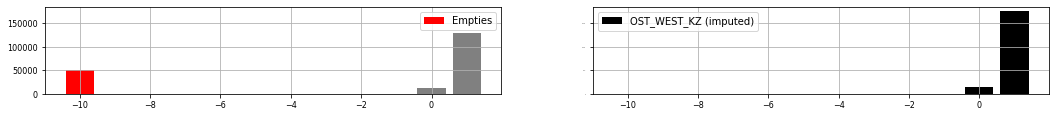

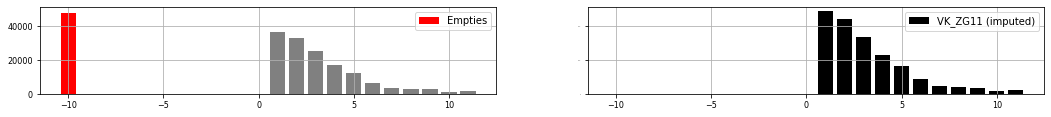

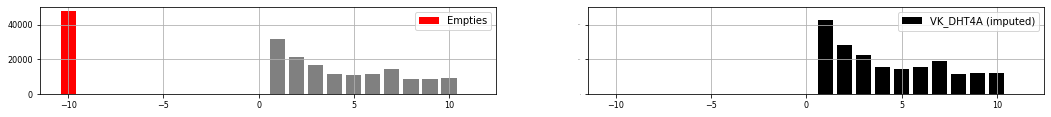

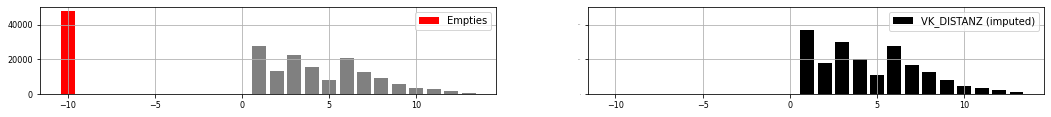

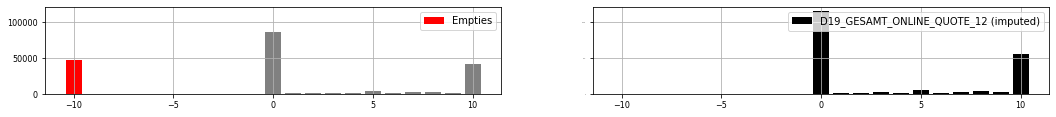

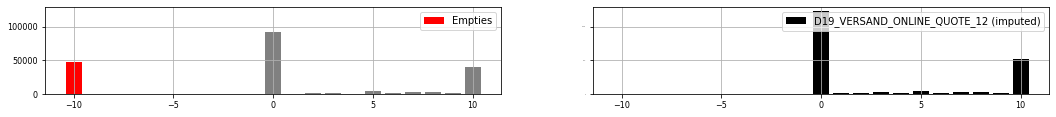

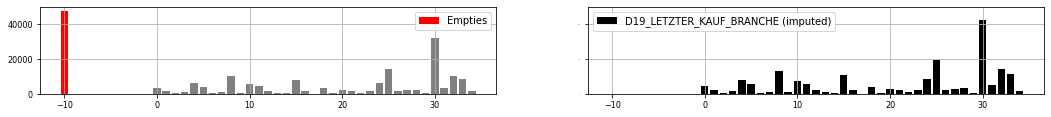

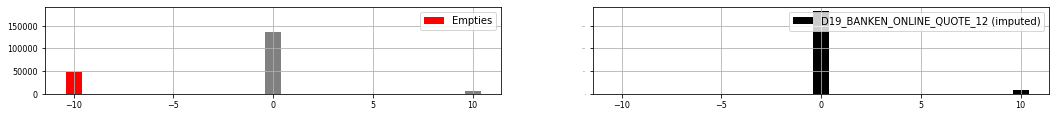

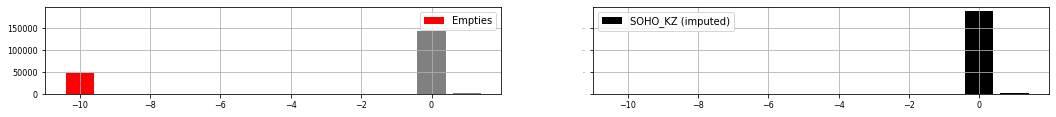

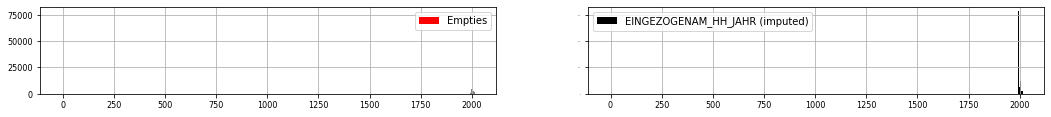

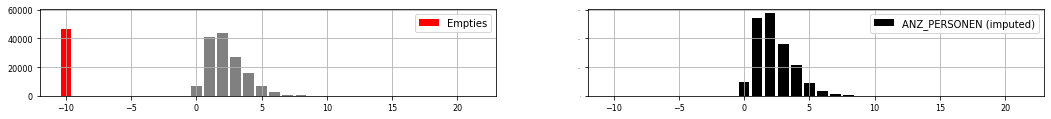

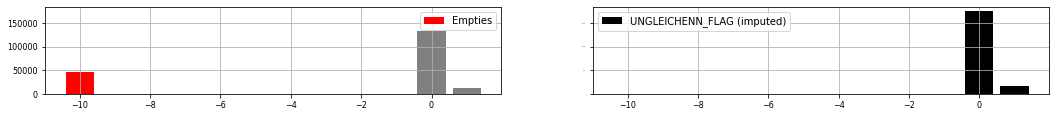

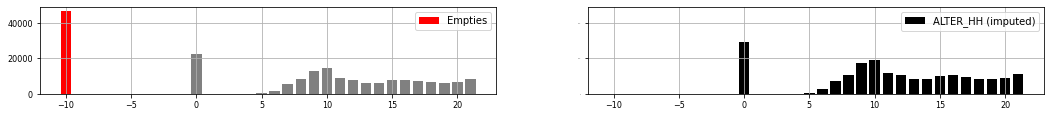

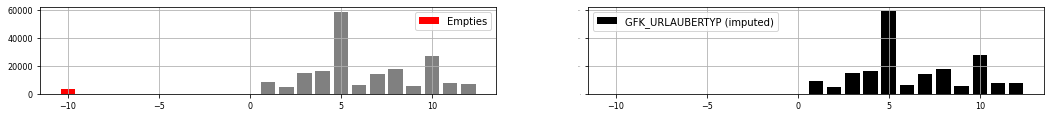

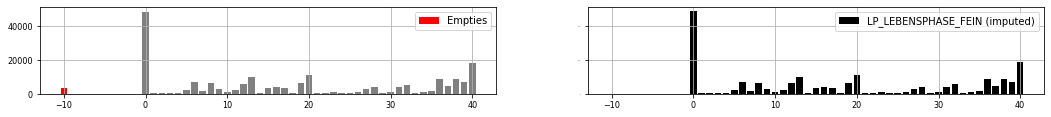

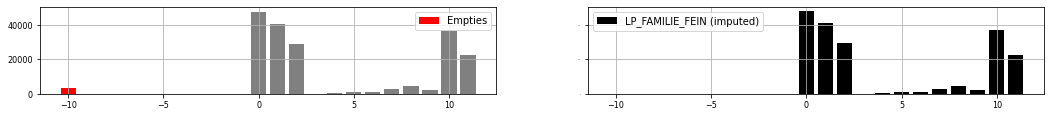

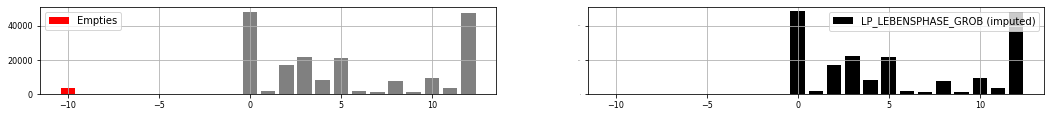

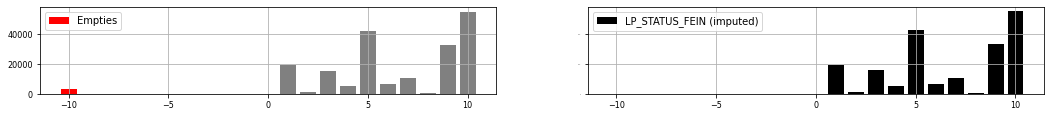

In [18]:
# Examine Customers missing data.
kunden_missing = kunden[kunden.isnull().mean().sort_values(ascending=False)[kunden.isnull().mean().sort_values(ascending=False) > 0].index[:]]
kunden_missing.head()
for feature in kunden_missing:
    data_exploration.before_and_after(kunden_missing[feature], feature, nanbin=-10, height=FIG_HEIGHT/5)

Here as well, with the exception of **'KBA13_ANZAHL_PKW, ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR'**, and **'EINGEZOGENAM_HH_JAHR'**, which require further examination, all others can be imputed.

In [19]:
# Remove columns from Customers missing list to prevent imputation.
kunden_missing.drop(['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR'], axis=1, inplace=True)

# Carryout imputations
for feature in kunden_missing:
    data_exploration.random_selection(kunden[feature])

The remaining five features in both datasets have a wider range of bins than normal; they may as well be considered numerical. We'll compare the result of imputation using the mean as well as the random selection method to decide on a course to follow. The function **`mean_or_rand_sel()`** displays the exaggerated lump of NaN entries below the minimum value, and also the result of imputing that lump using the mean or the random selection algorithm.

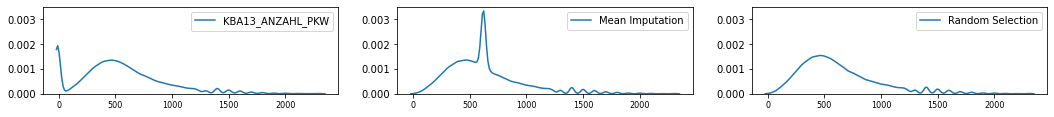

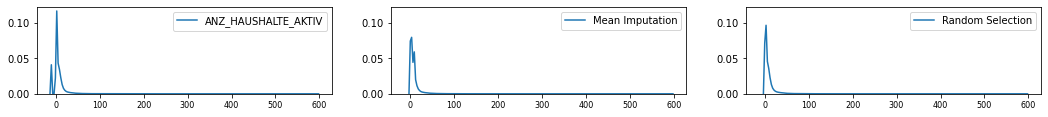

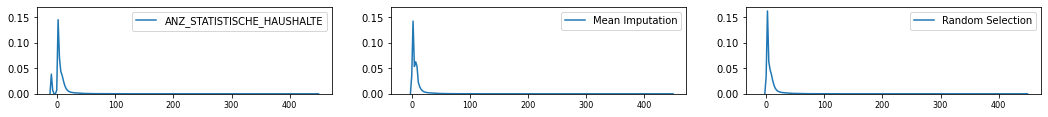

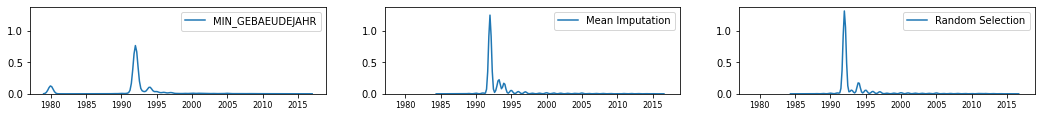

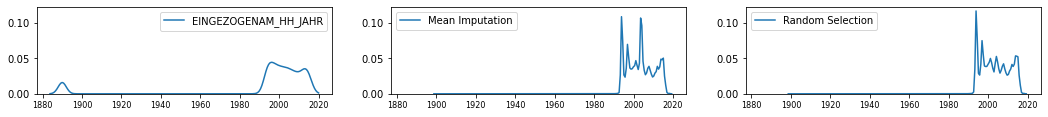

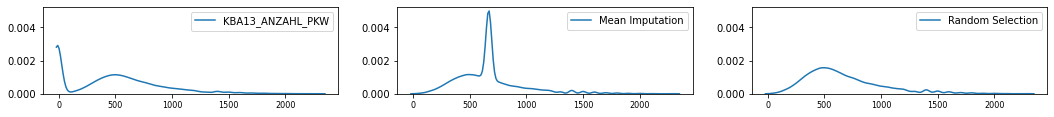

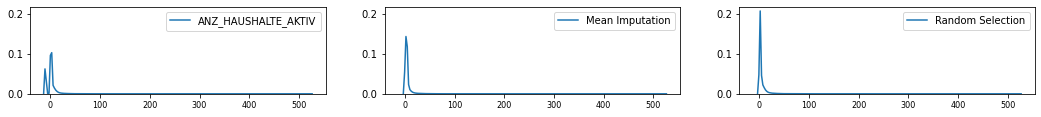

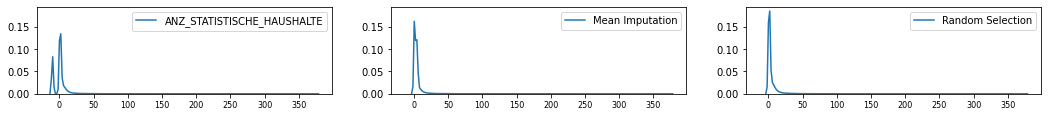

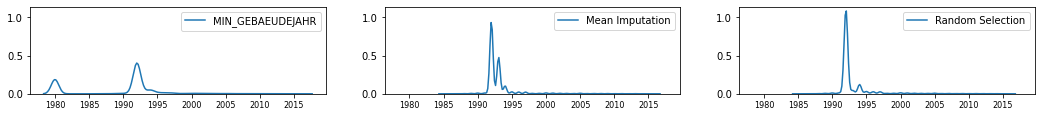

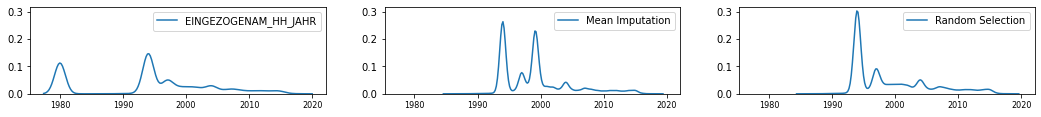

In [20]:
gp_still_missing = genpop[['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR']]
kd_still_missing = kunden[['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR']]
data_exploration.mean_or_rand_sel(genpop['KBA13_ANZAHL_PKW'], 'KBA13_ANZAHL_PKW', xrange=(-20,2350),  nanbin=-10)
data_exploration.mean_or_rand_sel(genpop['ANZ_HAUSHALTE_AKTIV'], 'ANZ_HAUSHALTE_AKTIV', xrange=(-20,600),   nanbin=-10)
data_exploration.mean_or_rand_sel(genpop['ANZ_STATISTISCHE_HAUSHALTE'], 'ANZ_STATISTISCHE_HAUSHALTE', xrange=(-20,450),   nanbin=-10)
data_exploration.mean_or_rand_sel(genpop['MIN_GEBAEUDEJAHR'], 'MIN_GEBAEUDEJAHR', xrange=(1970,2020), nanbin=1980)
data_exploration.mean_or_rand_sel(genpop['EINGEZOGENAM_HH_JAHR'], 'EINGEZOGENAM_HH_JAHR', xrange=(1880,2020), nanbin=1890)
data_exploration.mean_or_rand_sel(kunden['KBA13_ANZAHL_PKW'], 'KBA13_ANZAHL_PKW', xrange=(-20,2350),  nanbin=-10)
data_exploration.mean_or_rand_sel(kunden['ANZ_HAUSHALTE_AKTIV'], 'ANZ_HAUSHALTE_AKTIV', xrange=(-20,550),   nanbin=-10)
data_exploration.mean_or_rand_sel(kunden['ANZ_STATISTISCHE_HAUSHALTE'], 'ANZ_STATISTISCHE_HAUSHALTE', xrange=(-20,400),   nanbin=-10)
data_exploration.mean_or_rand_sel(kunden['MIN_GEBAEUDEJAHR'], 'MIN_GEBAEUDEJAHR', xrange=(1970,2020), nanbin=1980)
data_exploration.mean_or_rand_sel(kunden['EINGEZOGENAM_HH_JAHR'], 'EINGEZOGENAM_HH_JAHR', xrange=(1970,2020), nanbin=1980)

In all cases, imputation of these fetaures using the random selection procedure appears to produce best results.

In [21]:
# Impute the remaining features.
for feature in gp_still_missing:
    data_exploration.random_selection(genpop[feature])
for feature in kd_still_missing:
    data_exploration.random_selection(kunden[feature])

In [22]:
# Establish that no more data is missing.
print("Population missing entries: {}".format(genpop.isnull().sum().sum()))
print("Customer missing entries:   {}".format(kunden.isnull().sum().sum()))

Population missing entries: 0
Customer missing entries:   0


- **`Drop Columns:`** Handle the two features with no information, namely `D19_VERSI_ONLINE_QUOTE_12`, and `D19_TELKO_ONLINE_QUOTE_12`. The code cell below shows the justification for dropping them.
    - `D19_VERSI_ONLINE_QUOTE_12:` 8 bins with one taking up 99% of all data; this is a meaningless feature, a column to drop.
    - `D19_TELKO_ONLINE_QUOTE_12:` 5 bins, one taking 99%, drop!

In [23]:
print("Number of bins: {}".format(genpop['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
genpop['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).head(2)
print("-----------------------------------------------")
print("Number of bins: {}".format(genpop['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
genpop['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).head(2)

Number of bins: 8


0.0     0.997383
10.0    0.002455
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 5


0.0     0.998771
10.0    0.001193
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

In [24]:
# DROP One-Bin-takes-all categorical features D19_VERSI_ONLINE_QUOTE_12, and D19_TELKO_ONLINE_QUOTE_12
genpop.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)
kunden.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)

<br/>

## Handle Outliers
With categorical data, such as ours, it is difficult to tell if a high frequency slot is or isn't an outlier, particularly if there are few slots in the feature in question. We'd like to inspect only features with a large enough number of bins, so that a visual inspection would have a chance to reveal if something is out of the ordinary. We have very few such features with sufficient bins to check. The function **`pseudo_numericals`** displays the distribution of features exceeding some arbitrary number of bins, say 50, to visualize thusly. 

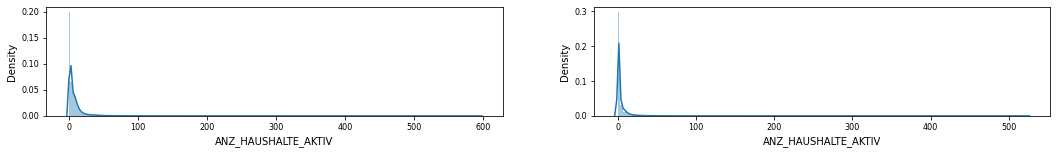

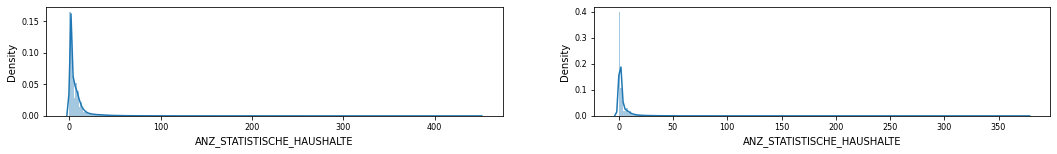

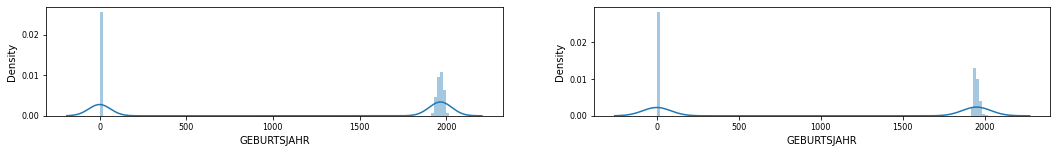

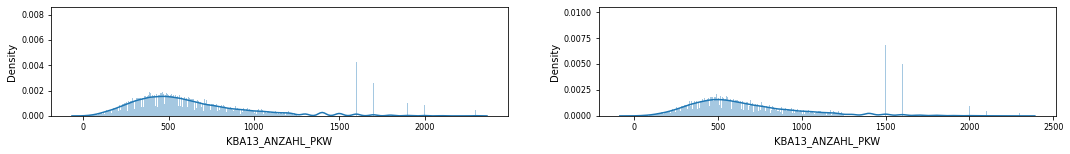

In [25]:
# Display the features for both General Population and Customers side by side.
data_exploration.pseudo_numericals(genpop, kunden)

Two features exhibit what appear to be outliers in both datasets, namely, **_`GEBURTSJAHR`_**, and **_`KBA13_ANZAHL_PKW`_**. 

The feature **_`GEBURTSJAHR`_**, German for _`Year Of Birth`_, shows many individuals being born in the year **_0_**. This entries are clearly not good data. We can impute this observations by painting them as NaNs, and thus mark them eligible for imputation with our **`random_selection()`** method, as shown in the code cell below.

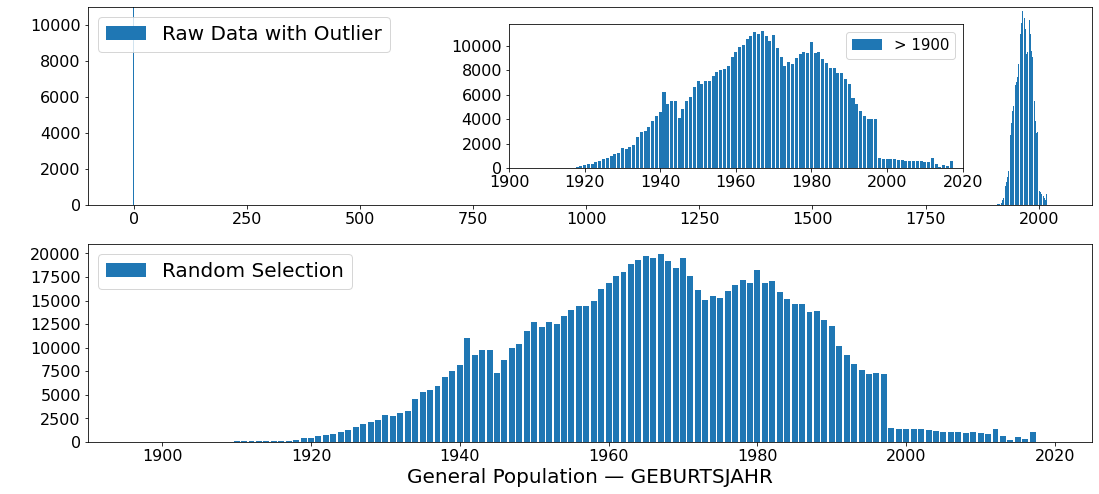

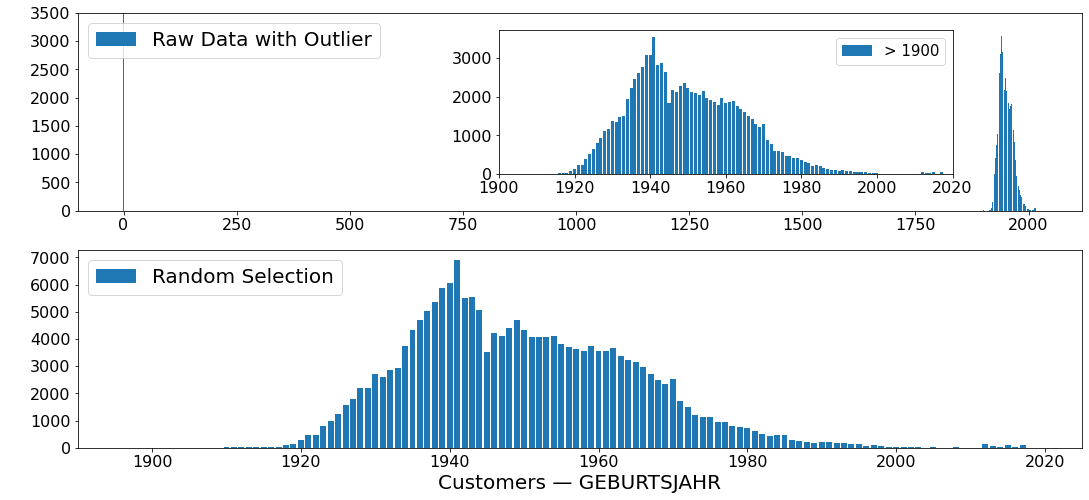

In [26]:
# Fix year zero noise in both datasets
data_exploration.anno_domini_outlier(genpop['GEBURTSJAHR'], 'General Population — GEBURTSJAHR', 11000)
data_exploration.anno_domini_outlier(kunden['GEBURTSJAHR'], 'Customers — GEBURTSJAHR', 3500)

<br/>The feature **_`KBA13_ANZAHL_PKW`_**, has an abrupt change in observational granularity at 1250. Below this value, we have granularity in units, but beyond 1250 the observations (11 in total) become coarse, with granularity in the hundreds, causing the entries to appear as outliers. This behaviour is present in both the `General Population` and `Customers` datasets — see output of code cell below.

There are 11 observations accounting for roughly 6% of the feature information. The function **`dequantize_right_tail()`**, redistributes the outliers into unit granular bins exclusively on the right tail. The back binning of observations follows a straight line pattern decaying to zero from a starting value chosen as the average of the last 100 unitary bin observations in the data. The use of a straight line, as well as the starting value for the decline are arbitrary decisions for the sake of expediency. The aim is to cast the outlier data into the right tail where it belongs, albeit in a smoother way (no jumps) resembling some kind of reality.

In [27]:
genpop['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)
genpop['KBA13_ANZAHL_PKW'].value_counts(normalize=True).sort_index(ascending=False).head(11).sum()
kunden['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)
kunden['KBA13_ANZAHL_PKW'].value_counts(normalize=True).sort_index(ascending=False).head(11).sum()

2300.0      694
2200.0      351
2100.0      745
2000.0     1377
1900.0     1662
1800.0     2956
1700.0     4281
1600.0     6959
1500.0     9388
1400.0    13288
1300.0     7288
1250.0      259
1249.0      160
1247.0       85
1246.0      191
Name: KBA13_ANZAHL_PKW, dtype: int64

0.054968408509224985

2300.0     107
2200.0      85
2100.0     165
2000.0     344
1900.0     439
1800.0     831
1700.0    1050
1600.0    1728
1500.0    2376
1400.0    3478
1300.0    1910
1250.0      81
1249.0      45
1247.0      21
1246.0      50
Name: KBA13_ANZAHL_PKW, dtype: int64

0.06529021351199048

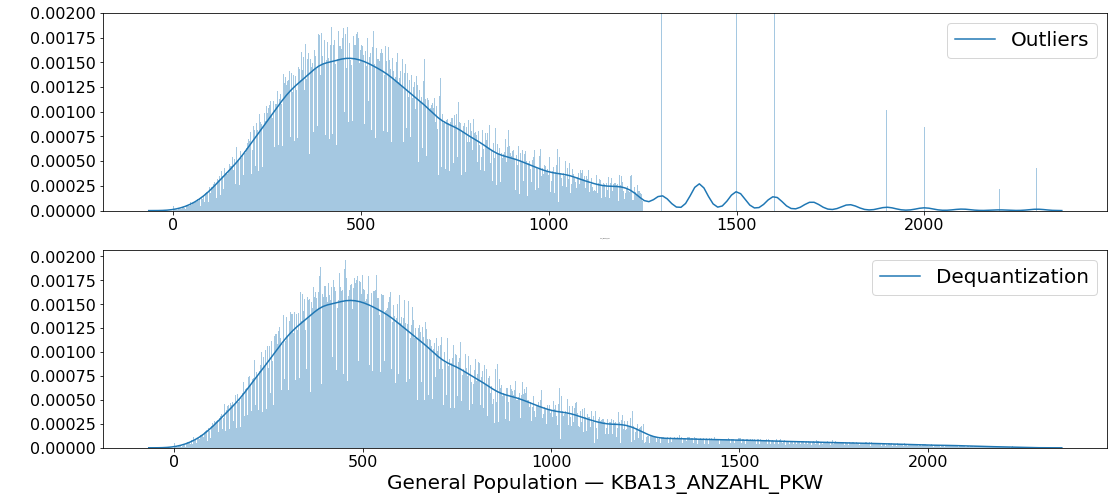

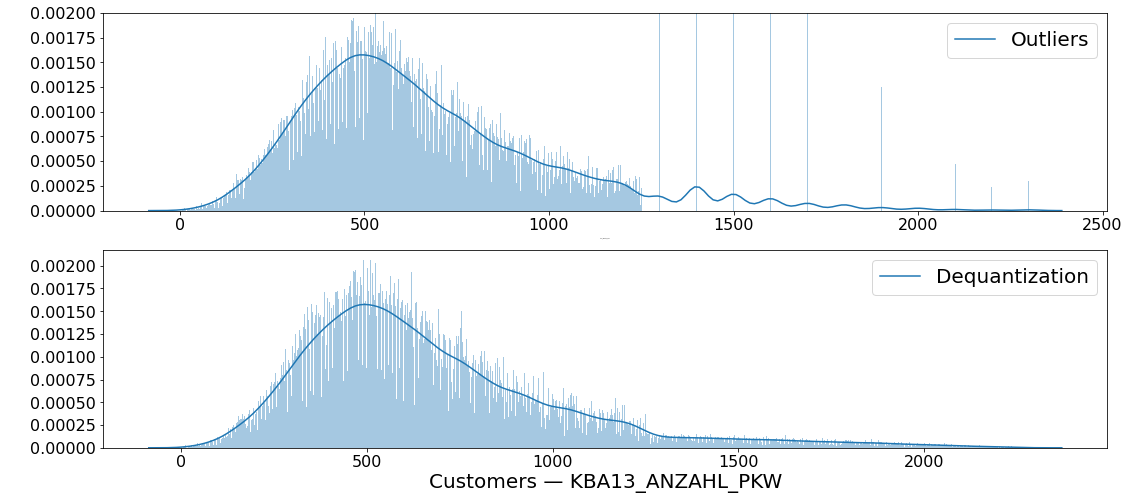

In [28]:
data_exploration.dequantize_right_tail(genpop['KBA13_ANZAHL_PKW'], 'General Population — KBA13_ANZAHL_PKW')
data_exploration.dequantize_right_tail(kunden['KBA13_ANZAHL_PKW'], 'Customers — KBA13_ANZAHL_PKW')

<br/><br/>
## Compare Datasets
We'd like to gain some insight as to how the distribution of each individual feature is different across the two datasets. The function **`flag_features()`** loops through all features and highlights any slots that diverge markedly between the datasets. Starting with the accepted hypothesis that the customers belong to the general population, we'd like to flag features (and their slots) which may lead us to reject this hypothesis. An arbitrary `tolerance` value, say 10%, is used to decide what constitutes over or undershooting. The point of highlighting is to focus our attention on the parts of the data where customers differ from the general population, rather than inspect all 366 features individually.

Consulting the EXCEL spreadsheets, we can examine the meaning of the flagged features and slots, and thus create a profile for the marketing campaigns. The function overshoot() implements a graphical depiction of any feature picked interactively for optical examination.

In [29]:
data_exploration.flag_features(genpop, kunden, .1)


                           AGER_TYP:   -0.28    0.01    0.12    0.13    0.01 
                         AKT_DAT_KL:    0.35    0.02   -0.01   -0.01   -0.01   -0.02   -0.01   -0.01   -0.29 
                           ALTER_HH:   -0.14    0.00   -0.00   -0.00    0.00    0.01    0.03    0.04    0.06    0.06    0.03    0.01   -0.00   -0.01   -0.01   -0.01   -0.02   -0.03   -0.02   -0.00    0.01 
Skipping ANZ_HAUSHALTE_AKTIV
Skipping ANZ_PERSONEN
Skipping ANZ_STATISTISCHE_HAUSHALTE
                             ARBEIT:    0.05    0.06    0.04   -0.13   -0.03   -0.00 
                    CAMEO_INTL_2015:    0.00    0.01    0.02    0.06    0.04    0.01    0.01    0.01    0.02   -0.00   -0.00   -0.00    0.01    0.00   -0.04   -0.00    0.00    0.00   -0.11   -0.02   -0.02   -0.00 
                      CJT_GESAMTTYP:    0.02    0.06   -0.05   -0.10   -0.04    0.10 
                  CJT_KATALOGNUTZER:   -0.08   -0.06   -0.06   -0.05    0.25 
                          CJT_TYP_1:    0.20    0.06  

                          FINANZTYP:   -0.20    0.11   -0.03    0.11    0.12   -0.10 
                    GFK_URLAUBERTYP:   -0.01   -0.03    0.01    0.01    0.17    0.00    0.03   -0.01   -0.04    0.02   -0.05   -0.12 
                   GREEN_AVANTGARDE:   -0.17    0.17 
                         HEALTH_TYP:    0.13    0.06   -0.05   -0.14 
                 HH_EINKOMMEN_SCORE:    0.10    0.21    0.02   -0.01   -0.10   -0.21 
                       KBA05_ALTER1:    0.03    0.11    0.02   -0.07   -0.07   -0.01 
                        KBA05_ANTG1:   -0.18   -0.06    0.04    0.09    0.10 
                        KBA05_ANTG3:    0.15   -0.05   -0.06   -0.05 
                        KBA05_ANTG4:    0.10   -0.05   -0.05 
                     KBA05_AUTOQUOT:   -0.07   -0.08   -0.01    0.13    0.05   -0.01 
                       KBA05_BAUMAX:   -0.06    0.19   -0.01   -0.04   -0.03   -0.06 
                         KBA05_CCM4:   -0.12    0.05    0.04    0.03    0.02   -0.01 
                

                     RETOURTYP_BK_S:   -0.12   -0.03    0.18   -0.06    0.04 
                     RT_KEIN_ANREIZ:    0.19    0.04   -0.09    0.08   -0.21 
                    RT_SCHNAEPPCHEN:   -0.04   -0.08   -0.08   -0.08    0.29 
                    RT_UEBERGROESSE:   -0.02    0.07    0.13    0.01   -0.11   -0.09 
                          SEMIO_DOM:   -0.00   -0.05    0.15   -0.09    0.02    0.10   -0.12 
                          SEMIO_ERL:   -0.04   -0.07    0.25   -0.03   -0.07   -0.08    0.05 
                          SEMIO_FAM:   -0.01   -0.04   -0.01    0.01   -0.01    0.17   -0.11 
                         SEMIO_KAEM:    0.04   -0.02    0.07   -0.05   -0.06    0.12   -0.09 
                         SEMIO_KRIT:    0.03   -0.05    0.17   -0.10   -0.07   -0.06    0.09 
                         SEMIO_KULT:   -0.01   -0.02    0.06    0.12   -0.06    0.02   -0.11 
                         SEMIO_LUST:   -0.09   -0.11   -0.08    0.02    0.20   -0.06    0.12 
                      

In [30]:
# For a single plot, non-interactive, use the following signature:
# data_exploration.comparator(genpop['XXX'], kunden['XXX'], .05, 'GenPop', 'Customers', FIG_WIDTH, FIG_HEIGHT)

# Interactive "Feature" selection requires that it be a widget arg. Pass the features, not the datasets.
def comparator_wrapper(df1, df2, label1, label2, feature, tolerance=0.05):
    data_exploration.comparator(df1[feature], df2[feature], tolerance, label1, label2, FIG_WIDTH, FIG_HEIGHT)

_ = interact(comparator_wrapper, df1=fixed(genpop), df2=fixed(kunden), \
             label1=fixed("German Population"), label2=fixed("Customers"), \
             feature=widgets.Dropdown(options=list(genpop.columns), description='Feature'), \
             tolerance=fixed(0.1))

interactive(children=(Dropdown(description='Feature', options=('AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKA…

Unfortunately, many of the flagged features are missing from the explanatory EXCEL spreadsheets; also, many of the flagged differences occur on slots dedicated to catching `unknown` values. For the rest of this exercise we'll ignore such unexplained featurees, and slots devoid of categorical significance.

Here is a brief description of how the customer distribution differs from the general population:
- **AGER_TYP:** CPassive and cultural elderly.
- **CJT_GESAMTTYP:** Consumption traditionalist and advertising enthusiast, but not interested in online shopping.
- **D19_HANDWERK:** Buyer of Do It Yourself products in the distant past (>2yrs).
- **D19_HAUS_DEKO:** Buyer of House Decoration products in the distant past (>2yrs).
- **D19_KONSUMTYP:** Active consumer of Universal, Versatile, and Gourmet products.
- **D19_KOSMETIK:** Buyer of Cosmetic products in the distant past (>2yrs).
- **D19_LOTTO:** Buyer of LOTTO products in the distant past (>2yrs).
- **D19_REISEN:** Buyer of Travel Related products in the distant past (>2yrs).
- **D19_SAMMELARTIKEL:** Buyer of Collectable Item products in the distant past (>2yrs).
- **D19_SONSTIGE:** Buyer of All Other Categories products in the distant past (>2yrs).
- **D19_VOLLSORTIMENT:** Buyer of Complete Mail-Order Offer products in the distant past (>2yrs).
- **FINANZ_ANLEGER:** Very high affinity as investor.
- **FINANZ_HAUSBAUER:** Average to high financial focus on the house.
- **FINANZ_MINIMALIST:** Average to low financial interest
- **FINANZ_SPARER:** Highly into saving.
- **FINANZ_UNAUFFAELLIGER:** Highly unremarkable financially.
- **FINANZ_VORSORGER:** Definitely not into preparing.
- **FINANZTYP:** Financially describable as a saver or investor.
- **GFK_URLAUBERTYP:** Fan of nature, but not a member of an active family.
- **GREEN_AVANTGARDE:** Belongs to the green avantgarde (Environmentalist??).
- **HEALTH_TYP:** Critically reserved health typology (??).
- **HH_EINKOMMEN_SCORE:** Has highest estimated household net income.
- **KBA05_ALTER1:** Low share of car owners younger than 31 years of age.
- **KBA05_ANTG1:** High share of 1-2 family houses in the cell.
- **KBA05_ANTG3:** Low share of 6-10 family houses in the cell.
- **KBA05_ANTG4:** Low share of >10 family houses in the cell.
- **KBA05_AUTOQUOT:** Very high share of cars per household.
- **KBA05_BAUMAX:** 1-2 family homes is the most common type of building in the cell.
- **KBA05_GBZ:** More than 17 buildings in the microcell.
- **KBA05_KW3:** Low share of cars with an engine power of more than 119 KW
- **KBA05_MAXAH:** Most common age of car owners in microcell is elder than 60 years.
- **KBA05_MAXVORB:** Most common preowner structure in the microcell is one preowner.
- **GREEN_AVANTGARDE:** Belongs to the green avantgarde (Environmentalist??).
- **KBA05_MOD1:** Low share of upper class cars (in an AZ specific definition).
- **KBA05_SEG5:** Low share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.).
- **KBA05_SEG8:** Low share of roadster and convertables in the microcell.
- **LP_FAMILIE_FEIN, LP_FAMILIE_GROB:** Not single.
- **LP_LEBENSPHASE_GROB:** high-income earners of higher age from multiperson households.
- **LP_STATUS_FEIN:** minimalistic high-income earners, top earners.
- **LP_STATUS_GROB:** Not low income earners.
- **MOBI_REGIO:** Low regional mobility.
- **NATIONALITAET_KZ:** Not foreign sounding names.
- **ONLINE_AFFINITAET:** Middle online affinity.
- **OST_WEST_KZ:** West German.
- **PLZ8_ANTG1:** High share of of 1-2 family houses in the zip code.
- **PLZ8_ANTG3:** Not a high share of 6-10 family houses in the PLZ8.
- **PLZ8_BAUMAX:** most common building-type within the zip codes is 1-2 family homes.
- **PRAEGENDE_JUGENDJAHRE:** Definitely not 90ies digital media kids.
- **RETOURTYP_BK_S:** incentive-receptive Normal-Returner, but not influenceable Crazy-Shopper.
- **SEMIO_DOM:** High affinity indicating in what way the person is dominant minded
- **SEMIO_ERL:** High affinity indicating in what way the person is eventful orientated.
- **SEMIO_FAM:** Low affinity indicating in what way the person is familiar minded.
- **SEMIO_KAEM:** Some high and some very low affinity indicating in what way the person is of a fightfull attitude.
- **SEMIO_KRIT:** High affinity indicating in what way the person is critical minded.
- **SEMIO_KULT:** Average affinity indicating in what way the person is cultural minded.
- **SEMIO_LUST:** Lowest affinity indicating in what way the person is sensual minded.
- **SEMIO_MAT:** Low affinity indicating in what way the person is material minded.
- **SEMIO_PFLICHT:** Some high and some low affinity indicating in what way the person is dutyfull traditional minded.
- **SEMIO_SOZ:** Some very low affinity indicating in what way the person is social minded.
- **SEMIO_TRADV:** High affinity indicating in what way the person is traditional minded
- **SHOPPER_TYP:** Not a familty shopper.
- **VERS_TYP:** Insurance typology of someone not individualistically accepting risk.
- **W_KEIT_KIND_HH:** Very unlikely likelihood of a child present in this household.
- **WOHNDAUER_2008:** length of residence more than 10 years.
- **ZABEOTYP:** Not a price driven type of energy consumer.
- **W_KEIT_KIND_HH:** Very unlikely likelihood of a child present in this household.
- **ANREDE_KZ:** Slightly higher proportion of males to females in the customers makeup.
- **ALTERSKATEGORIE_GROB:** age classification through prename analysis > 60 years.
<br/><br/>
<font color='blue'>The overall characterization of the differences in features' distributions of the customer and general population datasets shows customers to be shoppers of diverse products, but not online; they are financially unremarkable; they tend to save and invest, but not to prepare. They are fans of nature, with high income, residing longer than 10 years in areas of mostly 1-2 family homes, without children living at home, and not very interested in moving. They are environmentalists, but have multiple cars in the household. They are mostly old-fashioned (traditional minded) older males from the west of Germany, around 60 years of age, not single, top earners, with Germanic sounding names, dominant traits, critically minded, and not very social.</font>

<br/><br/>
## Part 1: Customer Segmentation Report
- **Standardize - Normalize Data**
- **Principal Component Analysis**
- **K-Means Clustering**

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<br/>

## Standardize - Normalize Data

One last processing step on the data is to standardize features by removing the mean and scaling to unit variance.
This process is necessary for the models we'll use later.

In [31]:
# Standardize, and keep numpy array as well as dataframe.
scaler = StandardScaler()
scaler = scaler.fit(genpop)
scaled_genpop = scaler.transform(genpop)
gp = DataFrame(scaled_genpop)

<br/><br/>
## Principal Component Analysis

We'd like to reduce the dimensionality of our data without sacrificing much of the information contained in it. With PCA we can map original data features onto a space of new features sorted by retained variance, i.e., the principal components. These principal components are linear combinations of the original features. But they are linearly independent and account for the largest variability in the data. Briefly, we want fewer new features, but the few good ones. The ones with the most variance!

We’ll use sklearn's IncrementalPCA class for linear dimensionality reduction. We'll first fit an IncrementalPCA object with the totality of the features to familiarize ourselves with the pattern in retained variance. We'll then examine the fraction of variance explained by each principal component, and plot the cumulative values using the function  **`show_pca(coeffs, given_PCA, Features=10)`** in the code cell below. This function allows us to visualize the feature weights of any of the PCA components to try and understand their meaning in terms of the original data features. The auxiliary function **`pca_features(given_PCA, Features=5)`** returns the same information as numbers.

In [32]:
# Apply PCA to the General Population data.
N_COMPONENTS=355 # Features - 1
ipca_explore = IncrementalPCA(n_components=N_COMPONENTS, batch_size=N_COMPONENTS)
_ = ipca_explore.fit_transform(scaled_genpop)

In [33]:
# Use show_feats(coeffs, given_PCA, cols, feat_count=10) for just the feature weights.
_ = interact(unsupervised_ML.show_pca, coeffs=fixed(ipca_explore),
             given_PCA=widgets.IntSlider(min=0, max=N_COMPONENTS-1, step=1, value=195),
             cols=fixed(genpop.columns.values),
             feat_count=widgets.IntSlider(min=5, max=50, step=1, value=5))

interactive(children=(IntSlider(value=195, description='given_PCA', max=354), IntSlider(value=5, description='…

With the `given_PCA` slider in the interactive code cell above, the PCA analysis reveals that we can retain 90% of the variance in the data by keeping 195 `Component Space Features`, a 45% dimensionality reduction at the cost of 10% of information in the data.

The `feat_count` slider can be adjusted to produce a detailed view of the feature weights associated with a given PCA component. The weights, whether positive, negative, large, or small, can be used to interpret their meaning in feature space. Here is a breakdown of the top three PCA Components:

**`PCA_0`** Results from **`unsupervised_ML.pca_features(0, genpop.columns.values, ipca_explore, 5)`**

| Feature           | Weight      | Meaning        |
|-------------------|-------------|:---------------|
| LP_STATUS_FEIN    | <span style='color:green'>+.123 </span> | social status fine |
| MOBI_REGIO        | <span style='color:green'>+.123 </span> | moving patterns |
| LP_STATUS_GROB    | <span style='color:green'>+.122 </span> | social status rough |
| D19_GESAMT_ANZ_24 | <span style='color:green'>+.120 </span> | transaction activity TOTAL POOL in the last 24 months |
| D19_GESAMT_DATUM	| <span style='color:red'>  -.120 </span> | actuality of the last transaction with the complete file TOTAL |

**`PCA_1`**  Results from **`unsupervised_ML.pca_features(0, genpop.columns.values, ipca_explore, 5)`**

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| KBA05_SEG6      | <span style='color:green'>+.179 </span> | share of upper class cars (BMW 7er etc.) in the microcell |
| KBA05_KRSOBER   | <span style='color:green'>+.164 </span> | share of upper class cars (referred to the county average) |
| KBA05_KRSVAN    | <span style='color:green'>+.161 </span> | share of vans (referred to the county average) |
| KBA05_KRSZUL    | <span style='color:green'>+.160 </span> | share of newbuilt cars (referred to the county average) |
| KBA05_ANHANG    | <span style='color:green'>+.154 </span> | share of trailers in the microcell |

**`PCA_2`**  Results from **`unsupervised_ML.pca_features(2, genpop.columns.values, ipca_explore, 5)`**

| Feature                 | Weight      | Interpretation |
|-------------------------|-------------|:---------------|
| ONLINE_AFFINITAET       | <span style='color:green'>+.144 </span> | online affinity |
| D19_GESAMT_ANZ_24       | <span style='color:green'>+.143 </span> | transaction activity TOTAL POOL in the last 24 months |
| PRAEGENDE_JUGENDJAHRE   | <span style='color:green'>+.141 </span> | very high online affinity |
| D19_GESAMT_ONLINE_DATUM | <span style='color:red'>  -.139 </span> | actuality of the last transaction with the complete file ONLINE |
| CJT_TYP_5               | <span style='color:red'>  -.137 </span> | ??? |

We now re-fit an IncrementalPCA instance with only 195 components, and perform the transformation to a reduced dimensionality dataset, namely **`gp_PCA`**, as shown in the code cell below. The code cell also shows a portion of the PCA components in terms of the original features' weights, and a section of the transformed General Population dataset.

In [34]:
# Re-apply PCA, selecting for number of components to retain.
REDUCED_DIM = 195
ipca = IncrementalPCA(n_components=REDUCED_DIM, batch_size=REDUCED_DIM)

_ = ipca.fit(scaled_genpop)
gp_PCA = ipca.transform(scaled_genpop)

# Show some of the PCA components
print("\n\nPCA Components {}".format(DataFrame(ipca.components_).shape))
PCA_components = DataFrame(ipca.components_, columns = genpop.columns.values)
PCA_components.index =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
PCA_components.head()

# Show some of the PCA transformed General Population dataset.
print("\n\nReduced Dimensionality General Population Dataset {}".format(DataFrame(gp_PCA).shape))
gp_PCA_df = DataFrame(gp_PCA)
gp_PCA_df.head()



PCA Components (195, 356)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,K



Reduced Dimensionality General Population Dataset (891221, 195)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194
0,-2.090223,1.026120,-3.844538,0.220473,0.151543,-1.165290,1.783616,-5.559462,-2.015039,0.398382,-0.182558,0.604642,0.806654,-0.477159,-0.125112,-0.888624,0.076775,0.015620,0.218626,-0.023876,-0.206436,0.187143,-0.557610,-0.327706,-1.193140,-0.326181,0.081791,-0.781086,-0.155158,-0.608751,-0.671926,-1.621827,1.142374,0.049826,0.202994,-0.061849,0.028184,-1.039445,-1.756930,1.643730,-1.424292,1.161122,0.498975,0.803742,0.289875,2.605389,-0.233761,0.701081,1.392119,-0.854360,0.374164,0.312130,0.695847,-0.429903,-1.122863,0.203227,0.795515,0.017457,0.382434,-0.031399,0.096201,-0.183932,-1.546153,-0.813257,-0.802475,-0.669420,0.126135,-0.447161,0.207922,-0.221971,0.253513,-0.811617,-0.353303,0.950771,-0.470026,-0.538859,-0.180311,1.914963,0.204110,0.074815,0.901285,-0.761798,-0.486591,1.325756,-0.695921,-0.707809,-0.833546,0.145638,-0.266484,1.015602,1.164511,-0.448306,-2.537598,0.797431,1.068010,-1.616139,-1.210127,0.657409,1.811343,1.471364,-0.456928,0.984189,-0.474277,-0.856119,-1.935769,-0.195783,-0.194005,1.750969,-0.683379,-1.391862,0.810969,0.810321,-0.136443,0.308887,-0.656699,0.478601,-1.040116,-0.599749,0.938240,0.661365,-0.879685,0.541430,0.243147,-0.942369,0.086132,-0.114400,-1.301558,-0.755053,-0.928132,-0.811496,0.328689,0.282916,0.086388,0.191118,0.297641,-0.607970,-0.771191,0.880924,-0.261234,-0.061081,0.851286,0.288838,0.462858,0.518793,0.730624,-0.549509,0.300491,-1.194471,-1.722722,-1.033963,-1.100340,0.274859,-0.061345,-0.782700,0.189848,-1.141328,-1.310140,-0.556167,0.178242,-0.194031,-0.273016,1.002849,-0.868759,0.285932,0.760238,0.850313,1.248561,1.330272,-1.259608,1.673190,-0.051707,-1.148226,0.169191,-0.418232,-0.081905,-0.068708,-0.911718,1.044539,-0.932925,2.288061,0.050063,0.831076,-0.549902,0.377583,-1.698283,-0.326293,1.980104,-0.504412,-0.160253,-0.267431,0.721904,1.303833,0.550050,0.347772,-0.784988
1,-4.636623,-2.206136,2.325694,4.863000,4.952204,-0.577905,0.797679,4.412629,-1.210407,1.050252,0.483422,1.974884,-1.922107,1.766529,0.568013,4.249239,-0.569683,1.340650,0.527916,-0.018349,-0.855071,0.772194,-2.322320,-2.754413,0.197332,-0.967594,-1.629402,0.850349,0.264065,-0.996271,-3.246285,-0.602534,0.522418,0.951447,0.619757,-0.036425,-0.586427,-1.751034,2.553293,1.056204,-0.349030,0.636066,0.957556,0.134262,1.526489,0.589123,1.678993,-1.006421,-0.030304,-0.385386,-0.248992,-0.667836,-1.942831,-0.320070,-1.115881,1.667749,-0.281845,-0.587156,-0.083526,-0.261898,-1.307427,0.287986,-1.833814,-1.383647,-0.187937,0.635675,-1.089401,-1.775984,4.654383,9.485058,-1.970059,1.007913,-1.156005,0.320635,-0.561624,0.472152,0.759489,-0.211033,-0.359624,0.150004,-0.678264,0.376683,0.745363,-0.929445,0.301849,0.273471,0.017516,-0.172054,0.128904,1.431296,-1.467320,-1.347993,0.337200,-2.141368,0.749096,1.571158,-1.393286,-0.460750,0.285840,0.671894,-1.104692,0.204456,0.714204,-0.079337,0.397460,-0.884824,0.194902,0.204403,0.230007,-0.600061,0.205852,0.358474,-0.162938,-0.274393,-0.526100,-0.340003,-0.402911,-0.082884,0.081745,0.596239,-0.454016,0.746028,0.111302,0.488470,-0.456610,-0.649044,0.238696,2.173912,-1.119191,-0.368705,-1.313912,-0.495517,0.040842,0.176553,0.152764,0.671160,-0.666437,-0.563379,-0.301122,0.666111,-0.043382,-0.743135,-0.223220,-1.759704,0.880069,0.232259,1.166400,0.401744,-1.047209,0.788000,0.690294,1.101898,-0.132504,-0.055970,0.764

<br/><br/>
## K-Means Clustering

We now reduce the complexity of our analysis by applying clustering to the PCA transformed General Population dataset. The function **`centroid_inertias()`** in the code cell below, loops through different numbers of clusters to observe the effect on the average centroid distance. We'd like to choose a value of **`k`** such that this distance is low, but not so low that we end up with too thinly populated clusters. If we select a good value for **`k`**, points in a cluster would be close to each other, the average centroid distance would be low, and we'd have enough points in each cluster to achieve effective segmentation of the data.

In [35]:
inertias = unsupervised_ML.centroid_inertias(gp_PCA_df, kmax=20)

k=2, k=3, k=4, k=5, k=6, k=7, k=8, k=9, k=10, k=11, k=12, k=13, k=14, k=15, k=16, k=17, k=18, k=19, 

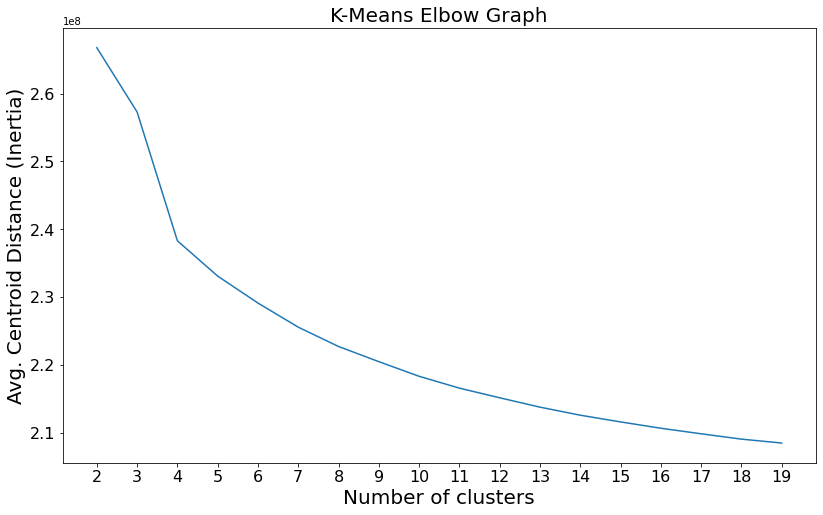

In [76]:
unsupervised_ML.elbow_graph(20, inertias)

The graph above shows the average cluster centroid distance plotted against the number of clusters attempted. There seems to be an elbow at **`k=4`**; the rate at which the average centroid distance decreases is much less sharp beyond **`k = 4`**. Further reduction with higher values of **`k`** is only marginally better. 

The code cell below performs K-Means clustering on the General Population using 4 clusters. This code cell also carries out all the prior transformation steps on the Customer dataset that were performed on the General Population. The actual Clusters are also shown in terms of Principal Components.

In [37]:
# Perform Clustering of the General Population
NUMBER_OF_CLUSTERS = 4
RANDOM_STATE = 403

kmeans_4 = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE)
clusters = kmeans_4.fit(gp_PCA_df)
gp_KM4_labels = clusters.predict(gp_PCA_df)

# Repeat all steps with the Customer Dataset
scaled_kunden = scaler.transform(kunden)   # Scale the data
kd_PCA195 = ipca.transform(scaled_kunden)  # Reduce Dimensionality
kd_KM4_labels = clusters.predict(kd_PCA195)   # Clustering

In [38]:
# Show the KMeans Clusters Centroid Locations in PCA component space.
print("KM Centroids {}".format(DataFrame(kmeans_4.cluster_centers_).shape))
KM4_PCA195_coordinates = DataFrame(kmeans_4.cluster_centers_)
KM4_PCA195_coordinates.index =  ['C_{}'.format(i) for i in range(len(kmeans_4.cluster_centers_))]
KM4_PCA195_coordinates.columns =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
KM4_PCA195_coordinates

KM Centroids (4, 195)


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,PCA_76,PCA_77,PCA_78,PCA_79,PCA_80,PCA_81,PCA_82,PCA_83,PCA_84,PCA_85,PCA_86,PCA_87,PCA_88,PCA_89,PCA_90,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100,PCA_101,PCA_102,PCA_103,PCA_104,PCA_105,PCA_106,PCA_107,PCA_108,PCA_109,PCA_110,PCA_111,PCA_112,PCA_113,PCA_114,PCA_115,PCA_116,PCA_117,PCA_118,PCA_119,PCA_120,PCA_121,PCA_122,PCA_123,PCA_124,PCA_125,PCA_126,PCA_127,PCA_128,PCA_129,PCA_130,PCA_131,PCA_132,PCA_133,PCA_134,PCA_135,PCA_136,PCA_137,PCA_138,PCA_139,PCA_140,PCA_141,PCA_142,PCA_143,PCA_144,PCA_145,PCA_146,PCA_147,PCA_148,PCA_149,PCA_150,PCA_151,PCA_152,PCA_153,PCA_154,PCA_155,PCA_156,PCA_157,PCA_158,PCA_159,PCA_160,PCA_161,PCA_162,PCA_163,PCA_164,PCA_165,PCA_166,PCA_167,PCA_168,PCA_169,PCA_170,PCA_171,PCA_172,PCA_173,PCA_174,PCA_175,PCA_176,PCA_177,PCA_178,PCA_179,PCA_180,PCA_181,PCA_182,PCA_183,PCA_184,PCA_185,PCA_186,PCA_187,PCA_188,PCA_189,PCA_190,PCA_191,PCA_192,PCA_193,PCA_194
C_0,-5.028985,-2.430204,2.043029,-0.294952,-1.432293,0.088765,-0.302268,0.556578,-0.011223,0.114606,0.137656,0.008979,-0.065510,0.057793,-0.059804,-0.006851,0.033898,0.086402,-0.096822,0.005665,-0.025116,0.018639,-0.005859,0.066055,0.019361,0.029742,-0.008008,-0.060446,0.010454,0.000190,0.013976,0.000458,0.040494,-0.008805,-0.053084,-0.021653,0.017524,0.018525,0.030702,0.001789,0.019641,-0.040602,-0.005961,0.026962,0.036208,-0.029001,0.040043,-0.036892,0.027385,0.000101,-0.039644,0.032558,-0.007953,-0.003601,-0.020399,0.007783,0.007026,-0.003373,0.008669,0.017329,-0.001110,0.004388,0.027473,0.019064,0.017655,0.020454,-0.005001,0.006778,-0.013268,0.006008,-0.008836,0.000490,-0.006721,-0.007204,0.028592,0.011887,0.004248,0.011501,-0.007567,0.006193,0.010198,0.000950,-0.019841,0.019749,0.002405,-0.002212,0.003793,-0.014174,0.001778,-0.010371,0.031472,-0.019273,0.022025,0.022293,-0.025217,-0.005026,0.008008,-0.033177,0.014596,-0.020224,-0.007997,0.033258,0.003133,0.005839,-0.004205,0.014114,0.001811,-0.015992,0.004558,0.010509,0.005527,-0.006961,-0.004641,0.008374,0.006346,-0.014163,0.009746,0.003156,0.004804,-0.010959,0.001343,0.012264,0.006233,0.007770,-0.009761,0.002832,0.000615,0.005367,-0.011801,0.000847,0.013578,-0.007083,0.005684,-0.005054,0.000201,-0.001287,0.013570,-0.021948,0.009457,-0.009534,0.000601,0.003157,-0.016903,0.001740,0.002561,-0.013655,-0.012808,-0.005122,0.008186,-0.006865,0.009736,-0.007874,-0.032508,0.012847,0.017328,0.011135,0.002661,-0.004081,0.001690,0.012740,0.018176,-0.004404,-0.001073,0.001492,0.001147,0.001049,0.010796,0.007091,-0.005118,0.004498,-0.020292,-0.013401,-0.018142,-0.014726,-0.002660,0.006777,0.038552,-0.009216,-0.009730,0.010985,0.004903,0.004211,0.005223,-0.002381,0.035186,-0.007965,-0.000184,-0.008915,-0.011727,0.001431,0.004800,0.021311,-0.018417,0.011240,0.000905
C_1,-9.199978,34.033507,6.715283,-3.145055,0.156468,0.310736,-0.316337,0.737303,0.029102,-0.230765,-0.383715,0.333262,-0.060252,0.550541,0.222944,-0.094746,-0.227122,-0.259360,0.210123,-0.126406,-0.052907,0.133899,0.029883,-0.105299,-0.287945,-0.025775,0.019731,0.122109,0.150028,0.067395,0.017414,0.263972,-0.033406,-0.053301,-0.006427,0.280128,0.066888,0.149614,0.042450,0.279117,0.032067,0.010124,0.097566,-0.030443,0.079293,0.012931,-0.131080,0.082800,0.016736,0.107688,0.008160,0.055140,-0.021222,0.052096,-0.004429,0.157452,-0.088864,-0.164162,-0.003331,-0.021648,-0.018615,0.044636,-0.086740,0.018262,0.052005,-0.026383,0.024875,-0.049283,-0.003060,0.004949,0.030611,-0.004821,-0.053000,-0.029201,0.1248

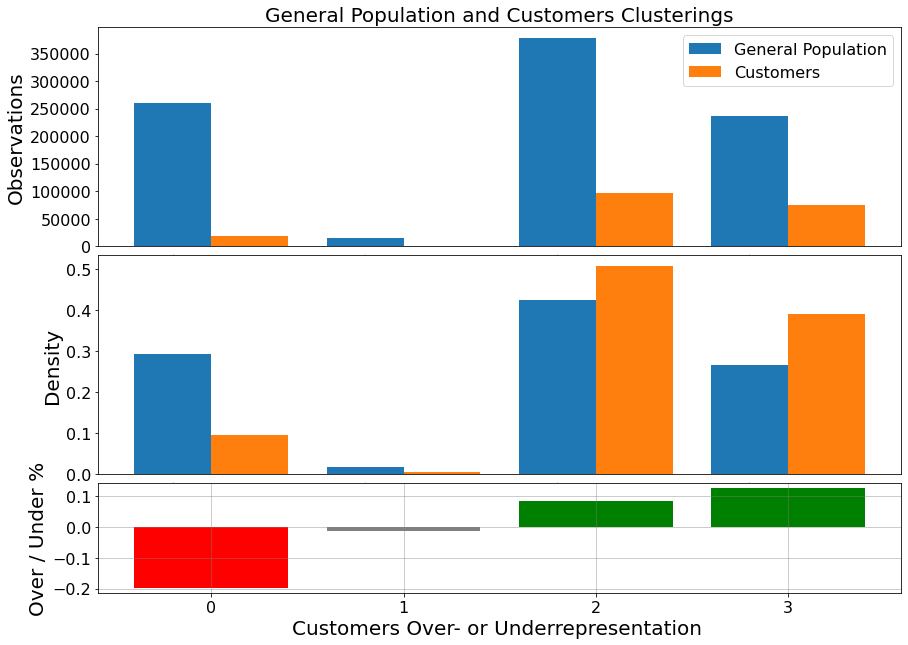

In [77]:
# Compare the clustering of both datasets
unsupervised_ML.clusterings(gp_KM4_labels, kd_KM4_labels, .05, "General Population", "Customers")

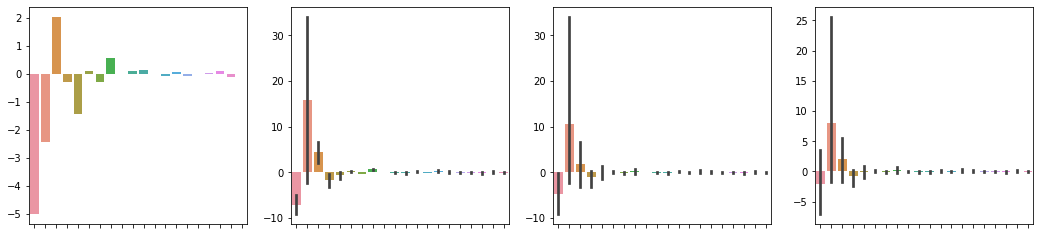

In [40]:
# Examine the range of cluster coordinates to avoid the heatmap getting 
# overshadowed by the extrema such as (C_2, PCA_1)
# Establish vmin, vmax values for each cluster to clip shadowing effect.
# Cluster coordinates beyond component 20 are mostly near the origin.
f = plt.figure(figsize=(FIG_WIDTH, .5*FIG_HEIGHT))
ax1 = f.add_subplot(141)
_ = sns.barplot(data=KM4_PCA195_coordinates.iloc[0:1,:20])
_ = ax1.set(xticklabels=[])
ax2 = f.add_subplot(142)
_ = sns.barplot(data=KM4_PCA195_coordinates.iloc[0:2,:20])
_ = ax2.set(xticklabels=[])
ax3 = f.add_subplot(143)
_ = sns.barplot(data=KM4_PCA195_coordinates.iloc[0:3,:20])
_ = ax3.set(xticklabels=[])
ax4 = f.add_subplot(144)
_ = sns.barplot(data=KM4_PCA195_coordinates.iloc[0:4,:20])
_ = ax4.set(xticklabels=[])
_ = plt.savefig('images/Cluster Coordinate Ranges.jpg', format='jpeg', dpi=1200)


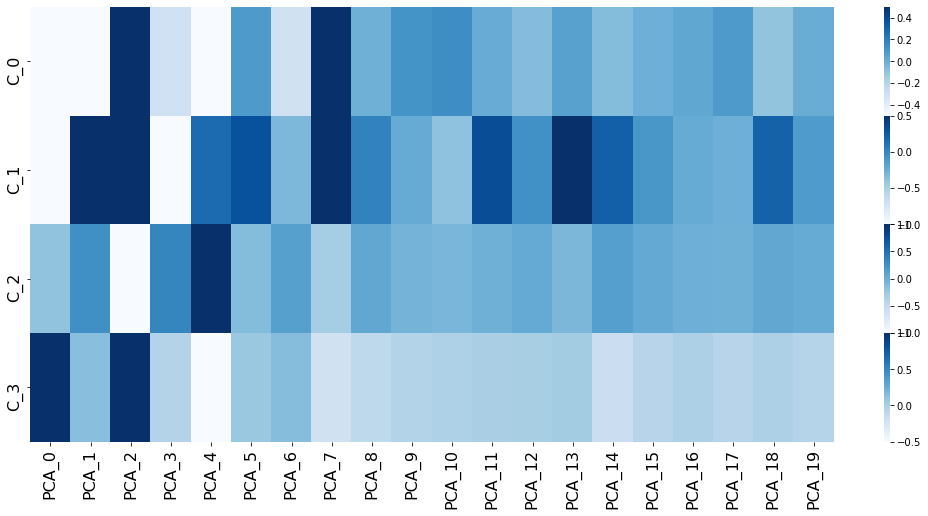

In [78]:
# Plot individual heatmaps for best shadow effect in order
# to visualize the PCA components of each cluster in their range.
unsupervised_ML.clusters_heatmap(KM4_PCA195_coordinates, 20, [-.5, .5, -1, .5, -1, 1, -.5, 1])

To understand what distinguishes a customer from the general population, we should look into the compositiion of the clusters. The function **`examine_clusterings()`** exposes the degrees of over and underrepresentation of the clusters with respect to the customer dataset vs the general population. The function also summarizes the higher coordinate PCA components and their corresponding features with weights.

In [42]:
unsupervised_ML.examine_clusterings(KM4_PCA195_coordinates, gp_KM4_labels, kd_KM4_labels, ipca, genpop.columns.values)

Cluster, Delta
3    12.51
2     8.38
1    -1.17
0   -19.71
dtype: float64

C_3 Overrepresentation by 12.51%
    PCA_0 : ['LP_STATUS_FEIN +12.35', 'MOBI_REGIO +12.28', 'LP_STATUS_GROB +12.21', 'D19_GESAMT_ANZ_24 +11.99', 'D19_GESAMT_DATUM -11.98']
    PCA_2 : ['ONLINE_AFFINITAET +14.4', 'D19_GESAMT_ANZ_24 +14.28', 'PRAEGENDE_JUGENDJAHRE +14.13', 'D19_GESAMT_ONLINE_DATUM -13.87', 'CJT_TYP_5 -13.7']
    PCA_6 : ['SEMIO_KAEM +34.44', 'ANREDE_KZ +33.28', 'SEMIO_VERT -32.39', 'SEMIO_DOM +30.62', 'SEMIO_KULT -29.85']
    PCA_1 : ['KBA05_SEG6 +17.89', 'KBA05_KRSOBER +16.33', 'KBA05_KRSVAN +16.1', 'KBA05_KRSZUL +15.98', 'KBA05_ANHANG +15.43']
    PCA_5 : ['KBA13_KW_0_60 +21.01', 'KBA13_KW_61_120 -20.9', 'KBA13_KMH_210 -19.42', 'KBA13_BJ_2000 +17.46', 'OST_WEST_KZ +17.35']
C_2 Overrepresentation by 8.38%
    PCA_4 : ['FINANZ_ANLEGER +18.51', 'FINANZ_SPARER +18.27', 'CJT_TYP_1 +17.78', 'FINANZ_UNAUFFAELLIGER +17.73', 'FINANZ_VORSORGER -16.96']
    PCA_3 : ['KBA13_HERST_BMW_BENZ +19.74', 'KBA13_ME

With the interactive tool **`overshoot()`**, we can examine feature by feature to deep dive into the ultimate meaning of the clusterings. We'll simplify our analysis by considering only the top five features that combine to make the PCA components of interest. Taking guidance from the EXCEL spreadsheets for the meaning of features, we'll briefly summarize the story that the clusters tell through the PCA components, and in turn through the main features.

|   | Cluster 3 Features| Meaning        |
|-----------|-------------------|:---------------|
| PCA_0     | LP_STATUS_FEIN, MOBI_REGIO, LP_STATUS_GROB, D19_GESAMT_ANZ_24, D19_GESAMT_DATUM| minimalistic high income earners, new homeowners, very low mobility |
| PCA_2     | ONLINE_AFFINITAET, D19_GESAMT_ANZ_24, PRAEGENDE_JUGENDJAHRE, D19_GESAMT_ONLINE_DATUM, CJT_TYP_5| unremarkable online presence, from 40's reconstruction years, 50's milk bar, 60's generation 68/student protestors |
| PCA_6     | SEMIO_KAEM, ANREDE_KZ, SEMIO_VERT, SEMIO_DOM, SEMIO_KULT| male, culturally minded |
| PCA_1     | KBA05_SEG6, KBA05_KRSOBER, KBA05_KRSVAN, KBA05_KRSZUL, KBA05_ANHANG| some upper class cars (BMW's), some trailers in microcell |
| PCA_5     | KBA13_KW_0_60, KBA13_KW_61_120, KBA13_KMH_210, KBA13_BJ_2000, OST_WEST_KZ| low share of cars built bet. 200-2003 in zip code, west Germans |

|   | Cluster 2 Features| Meaning        |
|-----------|-------------------|:---------------|
| PCA_4     | FINANZ_ANLEGER, FINANZ_SPARER, CJT_TYP_1, FINANZ_UNAUFFAELLIGER, FINANZ_VORSORGER | high investor typology, not a prepper, not so focused on house, high saver typology  |
| PCA_3     | KBA13_HERST_BMW_BENZ, KBA13_MERCEDES, KBA13_SEG_OBEREMITTELKLASSE, KBA13_SITZE_5, KBA13_BMW | very high share of BMW and Mercedes Benz in zip code, very few 5-seater cars |
| PCA_1     | KBA05_SEG6, KBA05_KRSOBER, KBA05_KRSVAN, KBA05_KRSZUL, KBA05_ANHANG | some upper class cars (BMW's), some trailers in microcell |
| PCA_14    | D19_BANKEN_ANZ_12, D19_BANKEN_ANZ_24, D19_BANKEN_DATUM, D19_BANKEN_ONLINE_DATUM, D19_BANKEN_ONLINE_QUOTE_12 | no known online banking transactions |
| PCA_6     | SEMIO_KAEM, ANREDE_KZ, SEMIO_VERT, SEMIO_DOM, SEMIO_KULT | male, culturally minded |

|   | Cluster 0 Features| Meaning        |
|-----------|-------------------|:---------------|
| PCA_2     | ONLINE_AFFINITAET, D19_GESAMT_ANZ_24, PRAEGENDE_JUGENDJAHRE, D19_GESAMT_ONLINE_DATUM, CJT_TYP_5 | unremarkable online presence, from 40's reconstruction years, 50's milk bar, 60's generation 68/student protestors  |
| PCA_7     | VERS_TYP, HEALTH_TYP, KOMBIALTER, SHOPPER_TYP, NATIONALITAET_KZ| demanding shopper, not foreign sounding |
| PCA_10    | LP_LEBENSPHASE_GROB, LP_LEBENSPHASE_FEIN, D19_BANKEN_ANZ_24, D19_BANKEN_ANZ_12, LP_FAMILIE_FEIN| high income earner-couples or older retiring high earners, multi-generational household |
| PCA_9     | KBA13_KMH_140_210, KBA13_CCM_1401_2500, KBA13_KRSZUL_NEU, KBA13_KW_30, KBA13_KMH_110| high share of new built cars in the zip code |
| PCA_5     | KBA13_KW_0_60, KBA13_KW_61_120, KBA13_KMH_210, KBA13_BJ_2000, OST_WEST_KZ| low share of cars built bet. 200-2003 in zip code, west Germans |

|   | Cluster 1 Features| Meaning        |
|-----------|-------------------|:---------------|
| PCA_1     | KBA05_SEG6, KBA05_KRSOBER, KBA05_KRSVAN, KBA05_KRSZUL, KBA05_ANHANG| some upper class cars (BMW's), some trailers in microcell |
| PCA_2     | ONLINE_AFFINITAET, D19_GESAMT_ANZ_24, PRAEGENDE_JUGENDJAHRE, D19_GESAMT_ONLINE_DATUM, CJT_TYP_5| unremarkable online presence, from 40's reconstruction years, 50's milk bar, 60's generation 68/student protestors  |
| PCA_7     | VERS_TYP, HEALTH_TYP, KOMBIALTER, SHOPPER_TYP, NATIONALITAET_KZ| demanding shopper, not foreign sounding |
| PCA_13    | KBA13_HERST_AUDI_VW, KBA13_VW, KBA13_KRSHERST_AUDI_VW, KBA05_GBZ, D19_BANKEN_ANZ_12| XXX |
| PCA_11    | LP_FAMILIE_FEIN, LP_FAMILIE_GROB, ANZ_PERSONEN, KBA13_HERST_AUDI_VW, KBA13_KRSHERST_AUDI_VW| multi-generational household, not single |

This exercise revealed that the population can be grossly considered to be comprised of four types of individuals, two of which (Clusters 3 and 0) are worthwhile pursuing with targeted marketing campaigns. A brief description of all the clusters follows:
- **Cluster 3 — Wealthy Older West German Males:** This group has the highest customer overrepresentation and consists of men who grew up in post-war West Germany. They are sedentary, culturally minded high income earners with an unremarkable online presence. Some are new homeowners and live in areas where there are some upper class cars, such as BMWs, and some trailers, but not many cars built between 2000 and 2003.
- **Cluster 2 — Money Savvy Wealthy Males:** Also strongly overrepresented with customers. These are men who save or invest their money, rather than spending it in the home, or being prepared; they are not known for online-banking.  They are culturally minded, and live in areas with a very high share of newly built cars as well as upper class cars, such as BMWs and Mercedes Benz, but not too many 5-seaters.
- **Cluster 0 — Power Couples & Retirees:** Hugely underrepresented with customers. These are either high-earning couples or retiring high-earners that live in multigenerational households in areas with a high share of newly-built cars. They have Germanic last names and are very demanding shoppers, but have an unremarkable online presence.
- **Cluster 1 — Older Couples & Households:** Also underrepresented with customers, this group consists mostly of people who are not single and who are living in multigenerational households. Nothing is known of their wealth status, but their online presence is unremarkable and they are very demanding shoppers. They have Germanic last names and grew up in post-war Germany.

We should remember that these observations are based on incomplete information. Many features were ignored when we decided to analyze the top five features per PCA component. Furthermore, of the features considered for analysis, several could not be decoded from the spreadsheets, and had to be ignored as well. But if we had to venture a guess as to where the firm ought to focus its marketing efforts, it would be on culturally minded men living in areas with a high share of new and upper class vehicles. Men who are either money savvy from anywhere in Germany, or wealthy and older “grandpa'' types from the west of the country. Conversely, not much can be gained by advertising to individuals who live in multigenerational households, regardless of wealth or share of new and upper class cars in their area. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

<br/>

The first order of business is to take the Mailout Data (Train and Test pieces) through the same preprocessing steps that we utilized with the unsupervised exercise datasets. These steps are briefly summarized here:
- **Retrieve Data:** We already took care of this step at the top of the notebook.
- **Explore Missing Data** 
- **Handle Missing Column Data**
- **Preprocess Features**
- **Impute Missing Data** 
- **Handle Outliers**

After the Data Exploration and Preprocessing steps above, we can attempt to find a model to predict how likely it is for an individual to respond positively to a marketing campaign. We'll do this in two steps; first we'll explore several classifiers, and then we'll optimize one by tuning its parameters. As an extra step, we'll explore the idea of mixing some of the unsupervised learning techniques with the supervised learning models, particularly the PCA dimensionality reduction. We'll discuss the pros and cons and examine the effects.
- **Model Selection**
- **Hyperparameter Tuning**
- **PCA Before Classification**

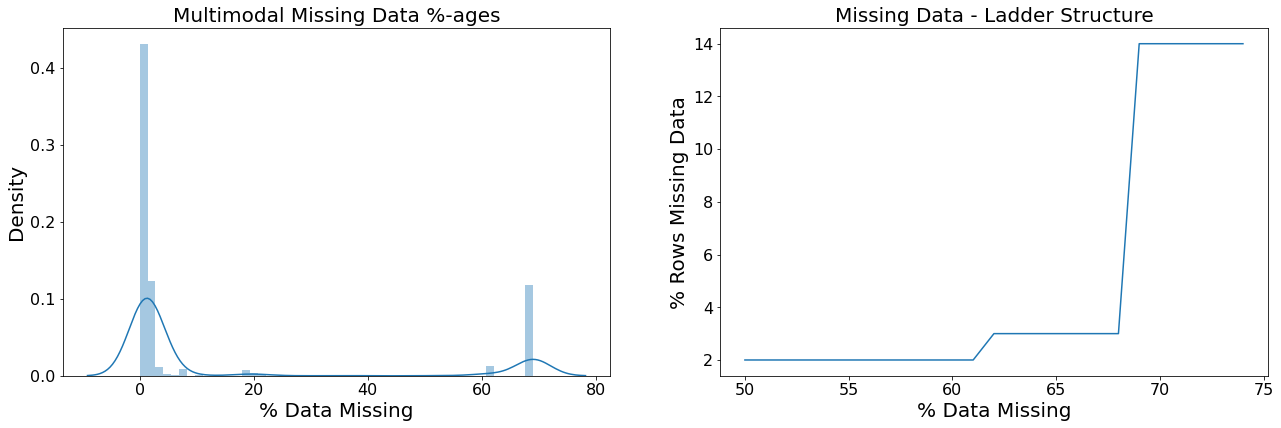

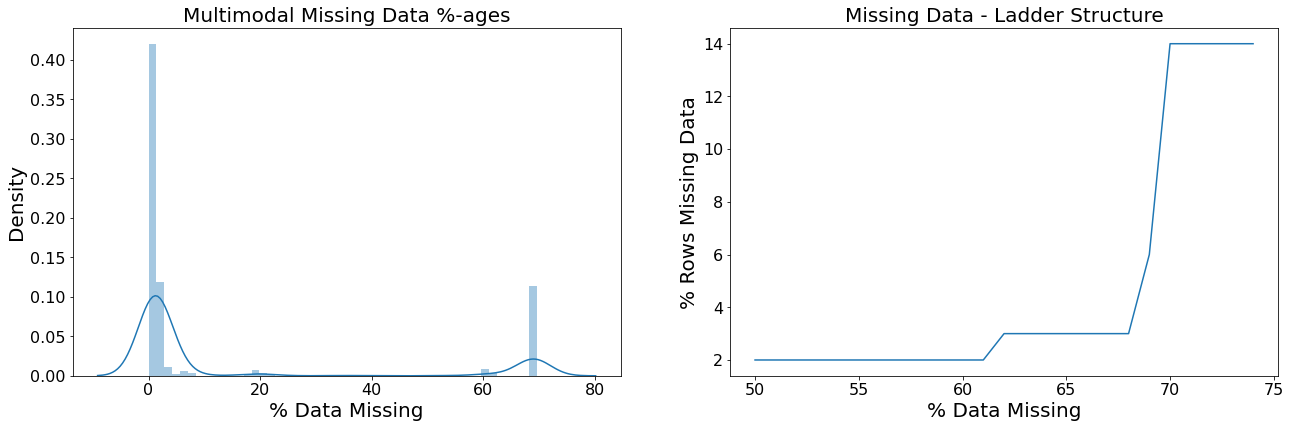

In [43]:
data_exploration.missing_data(mailed)
data_exploration.missing_data(totest)

Surprisingly, although the missing data exhibits jumps, this time they are less in quantity — a mixture of fewer sets?

In [44]:
mailed.head()
print("----- Types & Obj cols. ------")
mailed.describe(include=['object'])

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

----- Types & Obj cols. ------


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,35074,35074.0,35074.0,35378,35185,35185
unique,45,19.0,43.0,35,1599,2
top,6B,6.0,24.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,2452,3884.0,3024.0,10276,18156,26752


## Handle Missing Column Data

In [45]:
print("---------- Mailout Train - Missing Data High Offenders ----------")
mailed.isnull().mean().sort_values(ascending=False).head(10)

print("---------- Mailout Test - Missing Data High Offenders ----------")
totest.isnull().mean().sort_values(ascending=False).head(10)

---------- Mailout Train - Missing Data High Offenders ----------


ALTER_KIND4        0.999046
ALTER_KIND3        0.995950
ALTER_KIND2        0.982403
ALTER_KIND1        0.953727
KK_KUNDENTYP       0.589265
EXTSEL992          0.371212
W_KEIT_KIND_HH     0.225269
HH_DELTA_FLAG      0.225269
KBA05_KRSOBER      0.201294
KBA05_KRSHERST3    0.201294
dtype: float64

---------- Mailout Test - Missing Data High Offenders ----------


ALTER_KIND4       0.999089
ALTER_KIND3       0.995307
ALTER_KIND2       0.982210
ALTER_KIND1       0.953004
KK_KUNDENTYP      0.584479
EXTSEL992         0.369085
HH_DELTA_FLAG     0.224570
W_KEIT_KIND_HH    0.224570
KBA05_HERST4      0.199309
KBA05_FRAU        0.199309
dtype: float64

In [46]:
# Drop columns with excess (>40%) missing data
warnings.filterwarnings('ignore')
print("----- Mailout Train Data ------")
drop_mailed = data_exploration.dropoff(mailed, .4)
mailed.drop(drop_mailed, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_mailed))
print("Percent of data still missing: {:>3}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))


print("----- Mailout Test Data ------")
drop_totest = data_exploration.dropoff(totest, .4)
totest.drop(drop_totest, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_totest))
print("Percent of data still missing: {:>3}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

----- Mailout Train Data ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP']
Percent of data still missing:  13%
----- Mailout Test Data ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP']
Percent of data still missing:  13%


In [47]:
# Drop columns with no analytical value
mailed.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)

# Save the LNR column for kaggle submission
tt_LNR = totest["LNR"]
totest.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)

## Preprocess Features

In [48]:
mailed.describe(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,35074,35074.0,35074.0,35378,35185
unique,45,19.0,43.0,35,2
top,6B,6.0,24.0,D19_UNBEKANNT,W
freq,2452,3884.0,3024.0,10276,26752


In [49]:
# Perform encoding for the Mailout Train dataset
print("----- Mailout Train Data - Preprocessing features ------")
data_exploration.label_encode(mailed, 'CAMEO_DEU_2015')
data_exploration.label_encode(mailed, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.label_encode(mailed, 'OST_WEST_KZ')
data_exploration.disambiguate(mailed, 'CAMEO_DEUG_2015', "X")
data_exploration.disambiguate(mailed, 'CAMEO_INTL_2015', "XX")

# Perform encoding for the Mailout Test dataset
print("----- Mailout Test Data - Preprocessing features ------")
data_exploration.label_encode(totest, 'CAMEO_DEU_2015')
data_exploration.label_encode(totest, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.label_encode(totest, 'OST_WEST_KZ')
data_exploration.disambiguate(totest, 'CAMEO_DEUG_2015', "X")
data_exploration.disambiguate(totest, 'CAMEO_INTL_2015', "XX")

----- Mailout Train Data - Preprocessing features ------
[CAMEO_DEU_2015                ](BEFORE) : ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B' '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E' '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A' '5F' '1B' 'XX']
   ( AFTER) : [21. 19.  8. 31. 15. 20. nan 12. 18.  7. 13. 25.  0. 38. 14. 30. 17.  9. 32. 42. 35. 22. 36. 11. 28. 16.  6. 10. 34.  5. 26.  2. 27. 33.  3. 37. 39. 40. 41. 43. 29.  4. 24. 23.  1. 44.]
Mapping ==>> {0: '1A', 1: '1B', 2: '1C', 3: '1D', 4: '1E', 5: '2A', 6: '2B', 7: '2C', 8: '2D', 9: '3A', 10: '3B', 11: '3C', 12: '3D', 13: '4A', 14: '4B', 15: '4C', 16: '4D', 17: '4E', 18: '5A', 19: '5B', 20: '5C', 21: '5D', 22: '5E', 23: '5F', 24: '6A', 25: '6B', 26: '6C', 27: '6D', 28: '6E', 29: '6F', 30: '7A', 31: '7B', 32: '7C', 33: '7D', 34: '7E', 35: '8A', 36: '8B', 37: '8C', 38: '8D', 39: '9A', 40: '9B', 41: '9C', 42: '9D', 43: '9E', 44: 'XX'}
[D19_LETZTER_KA

## Impute Missing Data

In [50]:
data_exploration.impute(mailed)
data_exploration.impute(totest)

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [51]:
print("Population missing entries: {}".format(mailed.isnull().sum().sum()))
print("Customer missing entries:   {}".format(totest.isnull().sum().sum()))

Population missing entries: 218644
Customer missing entries:   223046


,EXTSEL992,HH_DELTA_FLAG,ANZ_HH_TITEL,ALTERSKATEGORIE_FEIN,KBA13_ANZAHL_PKW,VERDICHTUNGSRAUM,ORTSGR_KLS9,CAMEO_INTL_2015,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ,ANZ_STATISTISCHE_HAUSHALTE,MIN_GEBAEUDEJAHR,ANZ_HAUSHALTE_AKTIV,KONSUMZELLE,DSL_FLAG,D19_LETZTER_KAUF_BRANCHE,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,VK_ZG11,VK_DISTANZ,VK_DHT4A,SOHO_KZ,ALTER_HH,EINGEZOGENAM_HH_JAHR,ANZ_PERSONEN,UNGLEICHENN_FLAG,LP_FAMILIE_FEIN,GFK_URLAUBERTYP,LP_STATUS_FEIN,LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN
0,47.0,0.0,0.0,8.0,390.0,4.0,7.0,34.0,21.0,5.0,1.0,13.0,1992.0,15.0,1.0,1.0,30.0,0.0,0.0,1.0,2.0,5.0,0.0,8.0,2004.0,1.0,0.0,1.0,8.0,3.0,2.0,8.0
1,56.0,0.0,0.0,13.0,586.0,0.0,2.0,32.0,19.0,5.0,1.0,1.0,1994.0,1.0,0.0,1.0,27.0,0.0,0.0,1.0,2.0,1.0,0.0,13.0,1994.0,2.0,0.0,2.0,8.0,9.0,5.0,19.0
2,36.0,NaN,NaN,7.0,297.0,10.0,8.0,14.0,8.0,2.0,0.0,1.0,1995.0,0.0,0.0,1.0,18.0,0.0,0.0,2.0,4.0,6.0,0.0,9.0,1997.0,0.0,0.0,0.0,3.0,10.0,0.0,0.0
3,41.0,0.0,0.0,6.0,373.0,5.0,9.0,14.0,8.0,2.0,1.0,4.0,1992.0,4.0,0.0,1.0,30.0,0.0,0.0,11.0,11.0,8.0,0.0,6.0,1994.0,2.0,0.0,2.0,5.0,3.0,4.0,16.0
4,55.0,0.0,0.0,9.0,285.0,4.0,7.0,41.0,31.0,7.0,1.0,44.0,1992.0,53.0,0.0,1.0,4.0,0.0,0.0,1.0,2.0,2.0,0.0,9.0,1994.0,1.0,0.0,1.0,4.0,6.0,3.0,9.0


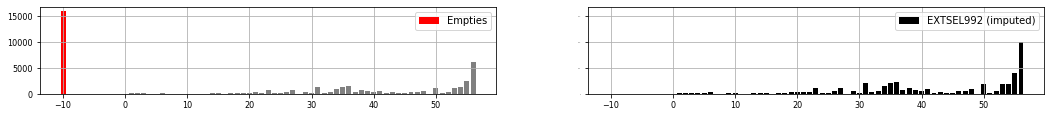

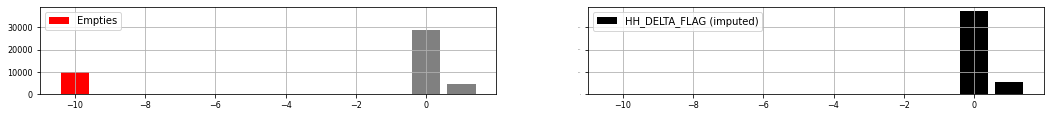

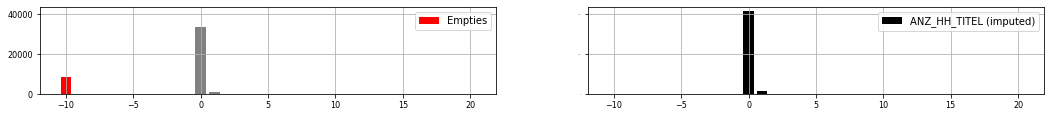

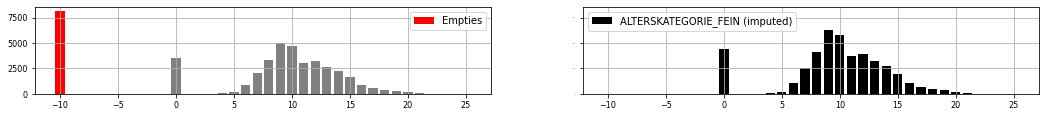

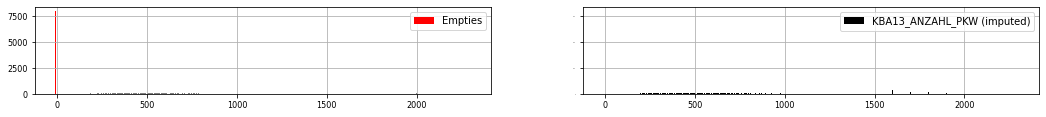

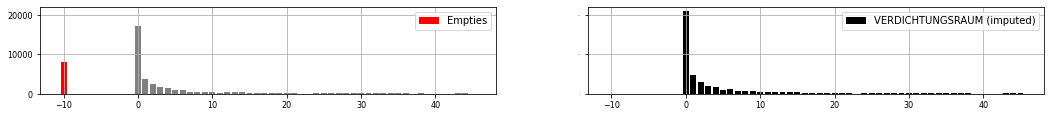

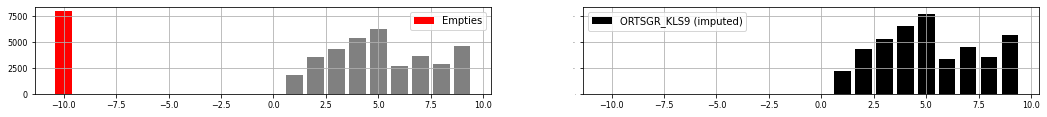

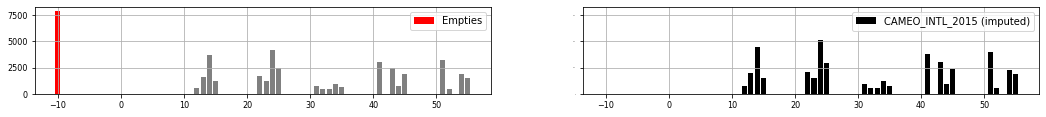

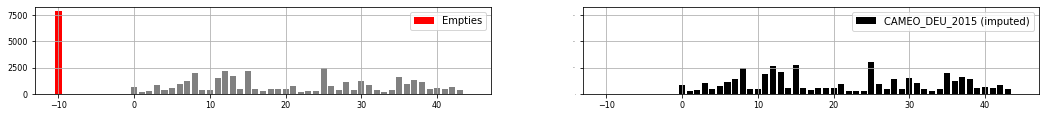

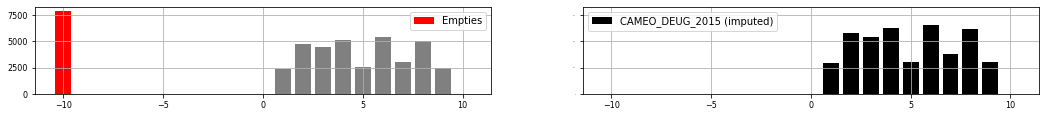

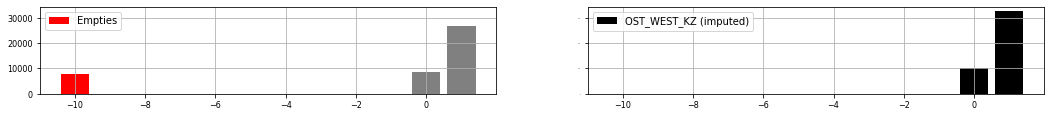

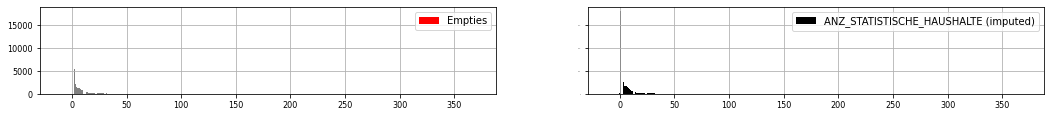

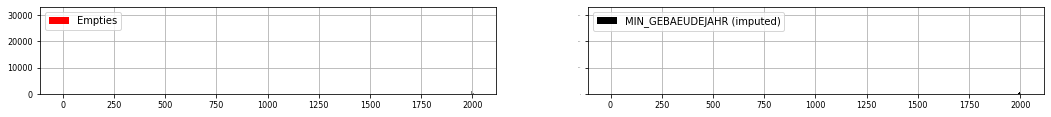

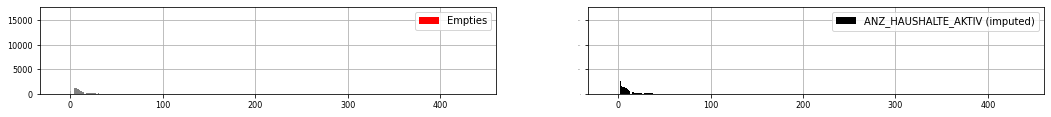

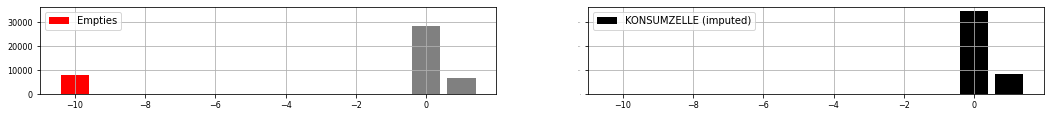

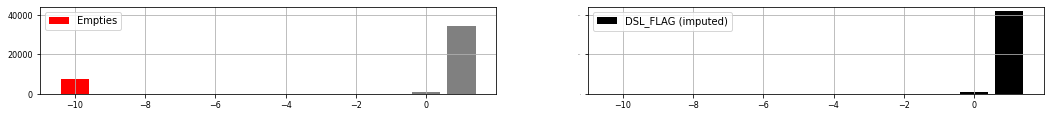

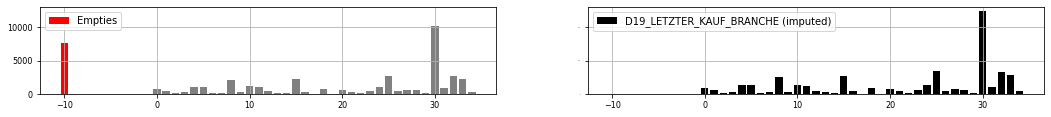

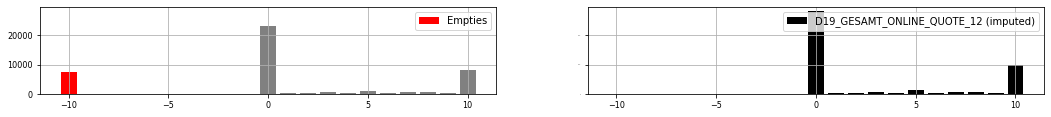

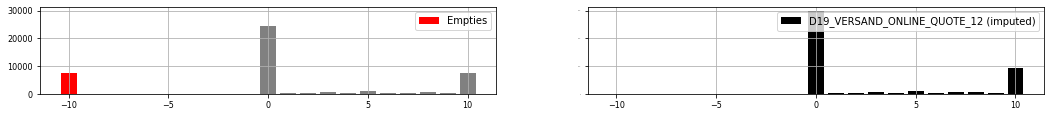

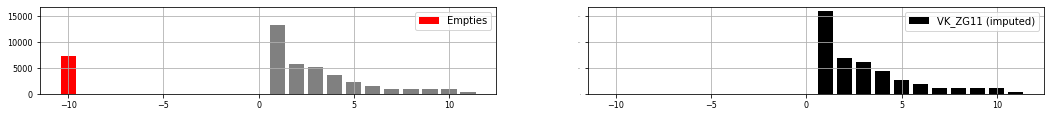

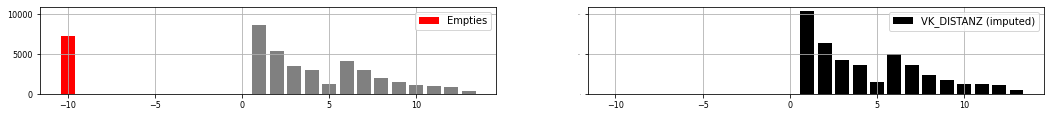

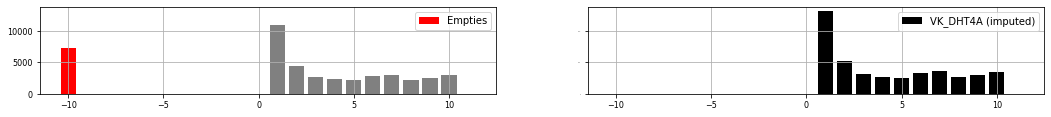

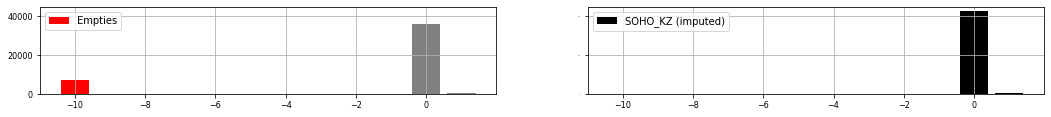

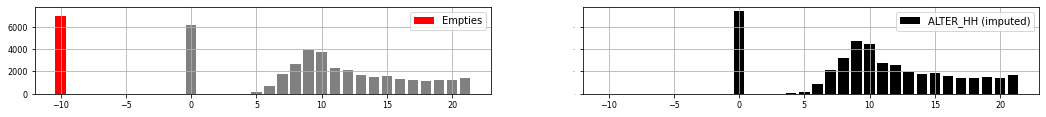

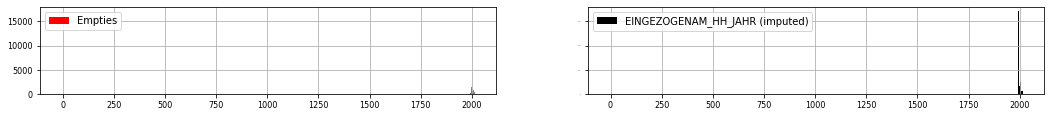

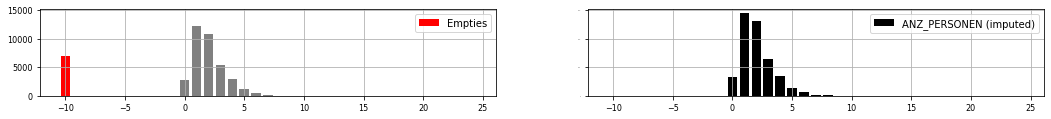

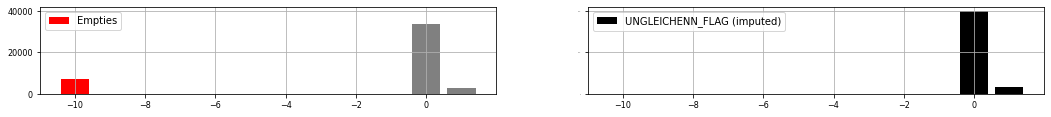

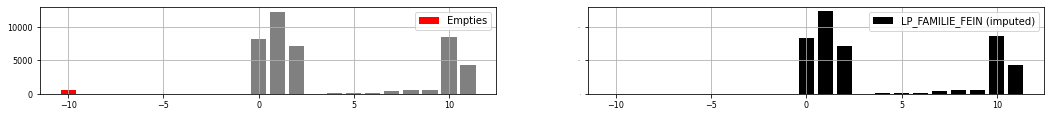

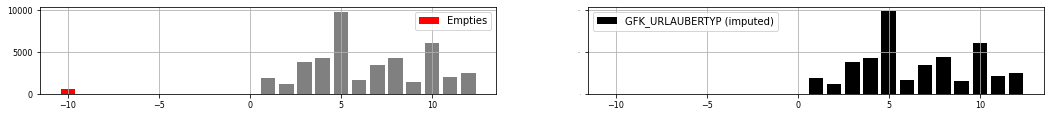

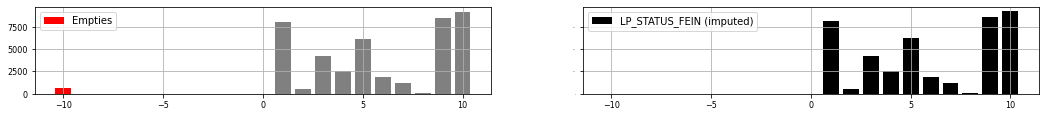

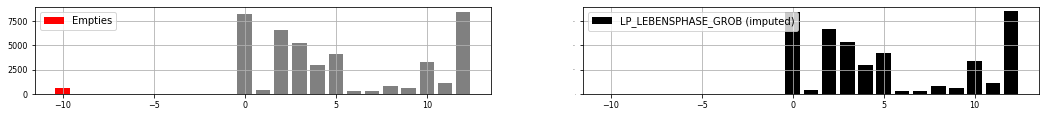

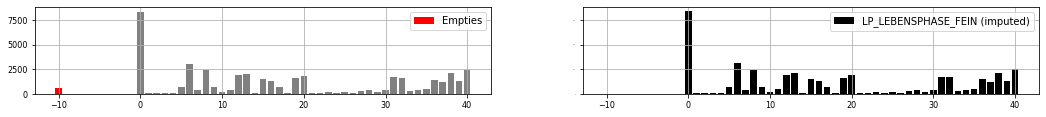

,EXTSEL992,HH_DELTA_FLAG,ANZ_HH_TITEL,ALTERSKATEGORIE_FEIN,KBA13_ANZAHL_PKW,VERDICHTUNGSRAUM,ORTSGR_KLS9,CAMEO_DEUG_2015,CAMEO_INTL_2015,CAMEO_DEU_2015,OST_WEST_KZ,KONSUMZELLE,DSL_FLAG,MIN_GEBAEUDEJAHR,ANZ_STATISTISCHE_HAUSHALTE,ANZ_HAUSHALTE_AKTIV,D19_LETZTER_KAUF_BRANCHE,D19_VERSAND_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,VK_ZG11,VK_DISTANZ,VK_DHT4A,EINGEZOGENAM_HH_JAHR,ANZ_PERSONEN,SOHO_KZ,UNGLEICHENN_FLAG,ALTER_HH,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,GFK_URLAUBERTYP,LP_STATUS_FEIN,LP_LEBENSPHASE_FEIN
0,34.0,0.0,0.0,6.0,412.0,23.0,4.0,2.0,13.0,6.0,1.0,0.0,1.0,1993.0,2.0,2.0,4.0,10.0,0.0,10.0,3.0,6.0,5.0,1994.0,2.0,0.0,0.0,7.0,5.0,2.0,10.0,10.0,20.0
1,47.0,0.0,0.0,0.0,935.0,0.0,5.0,5.0,31.0,18.0,1.0,0.0,1.0,1992.0,21.0,20.0,30.0,0.0,0.0,0.0,1.0,2.0,5.0,1998.0,1.0,0.0,0.0,0.0,2.0,1.0,10.0,1.0,6.0
2,35.0,1.0,0.0,11.0,693.0,15.0,6.0,7.0,41.0,30.0,1.0,1.0,1.0,1992.0,2.0,2.0,30.0,0.0,0.0,0.0,3.0,6.0,9.0,1994.0,4.0,0.0,1.0,16.0,12.0,10.0,5.0,10.0,40.0
3,31.0,NaN,0.0,0.0,326.0,10.0,8.0,2.0,13.0,6.0,0.0,0.0,1.0,1992.0,1.0,1.0,18.0,0.0,0.0,0.0,3.0,6.0,6.0,1994.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0
4,36.0,1.0,0.0,13.0,134.0,0.0,3.0,5.0,31.0,18.0,1.0,0.0,1.0,1992.0,1.0,1.0,1.0,5.0,10.0,7.0,3.0,4.0,2.0,2000.0,4.0,0.0,0.0,21.0,12.0,11.0,10.0,9.0,37.0


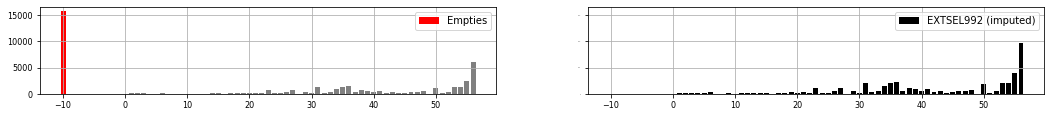

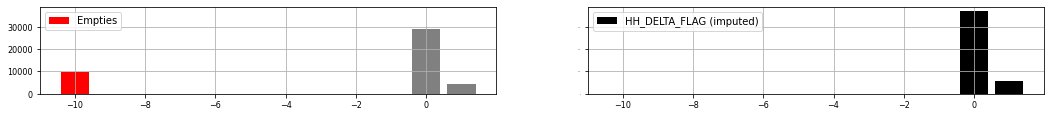

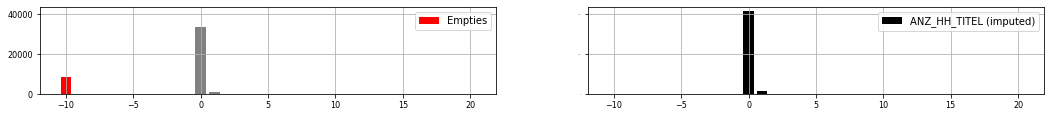

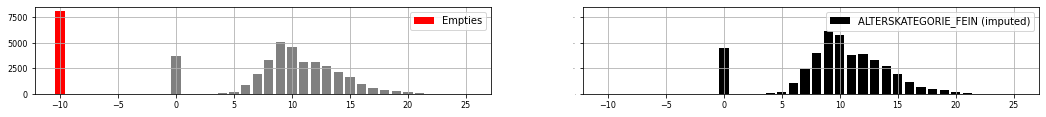

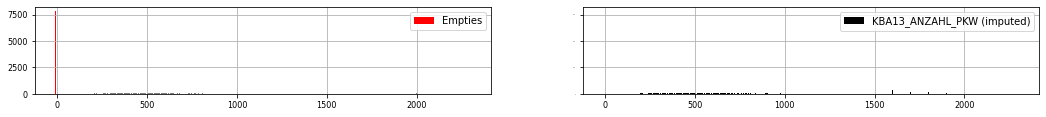

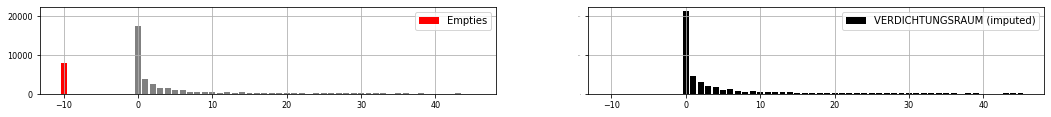

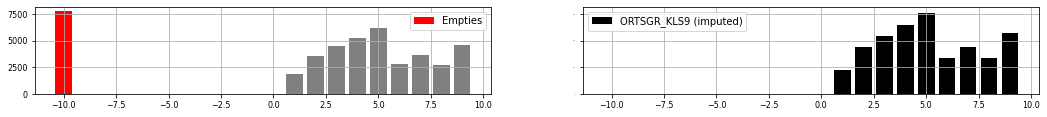

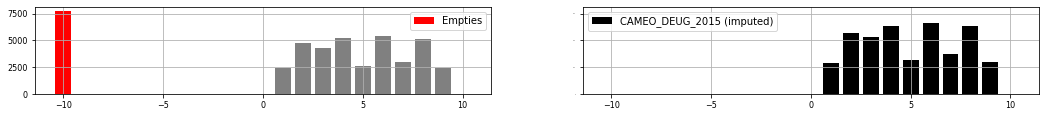

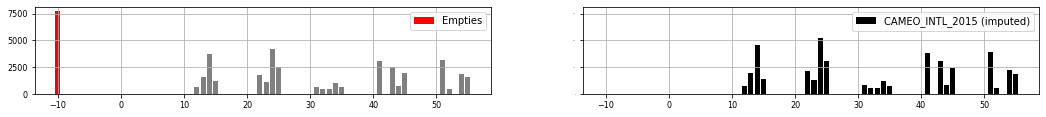

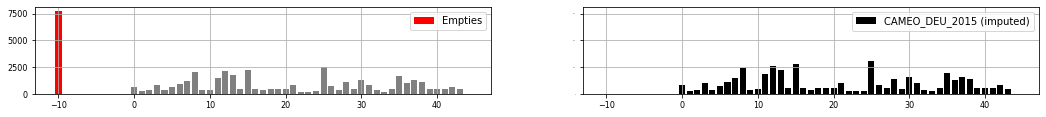

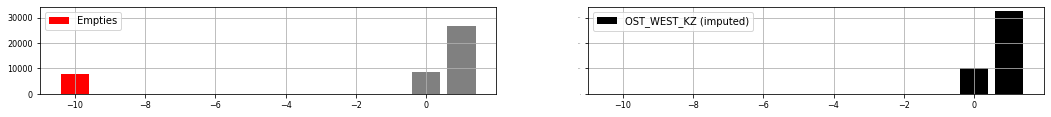

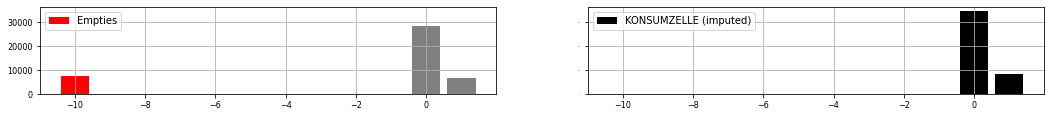

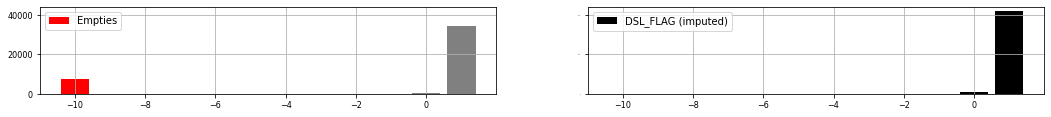

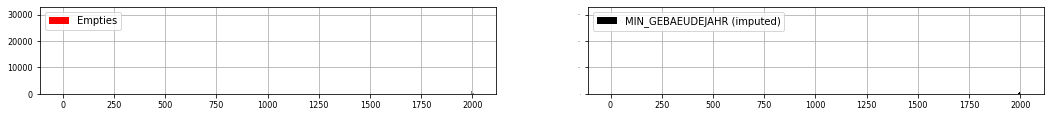

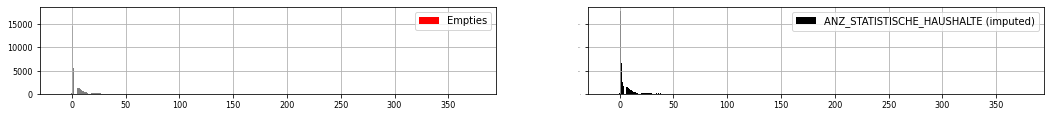

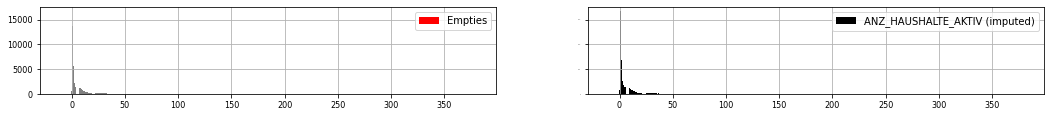

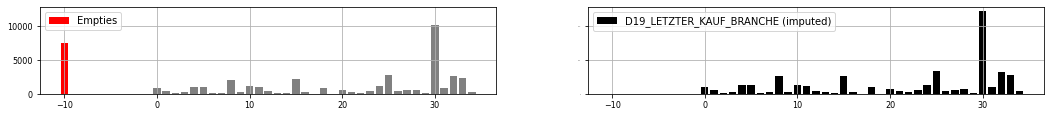

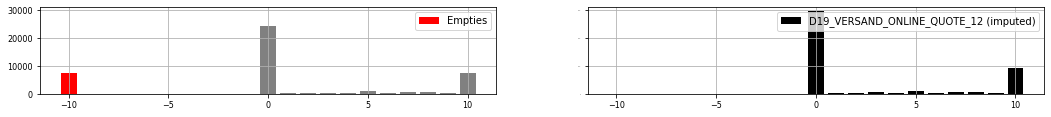

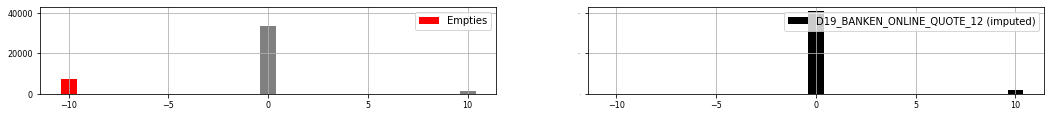

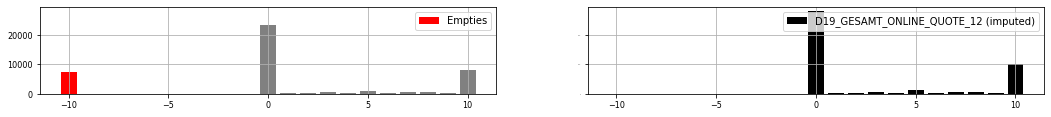

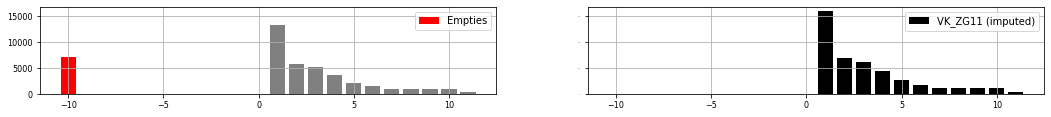

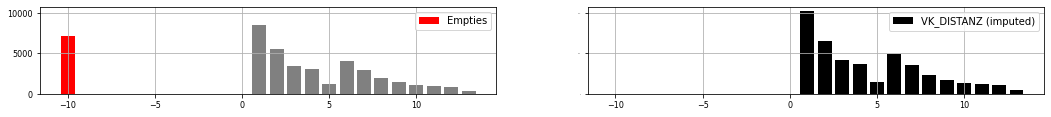

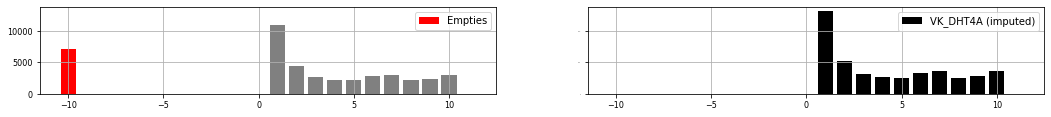

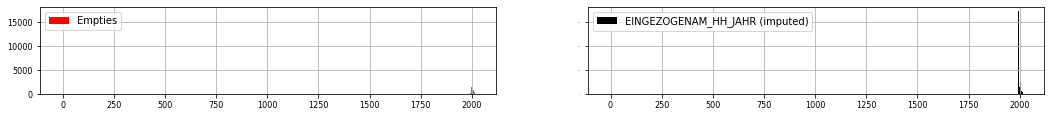

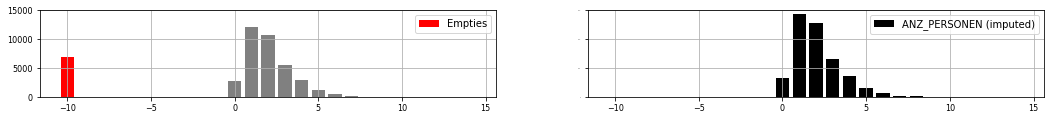

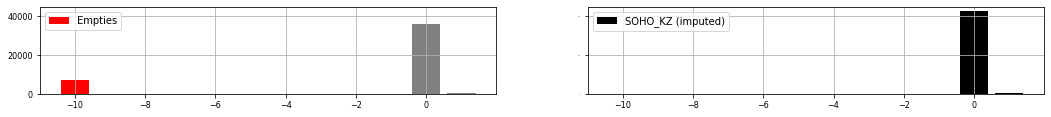

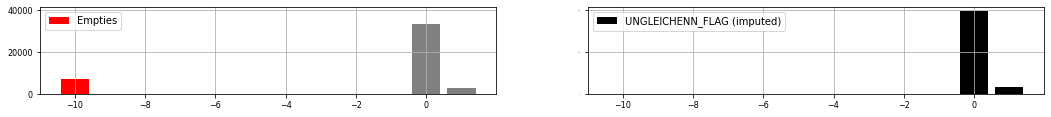

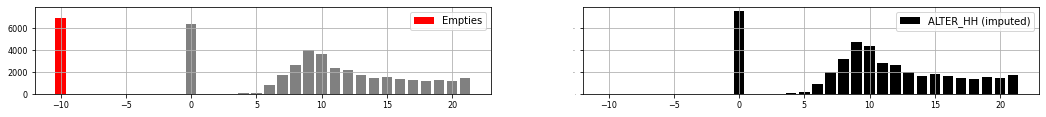

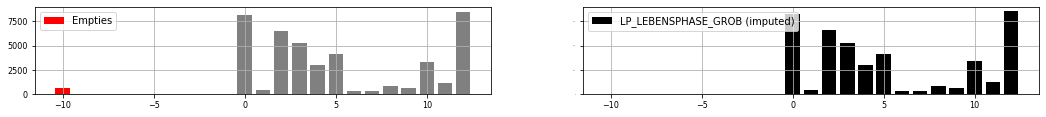

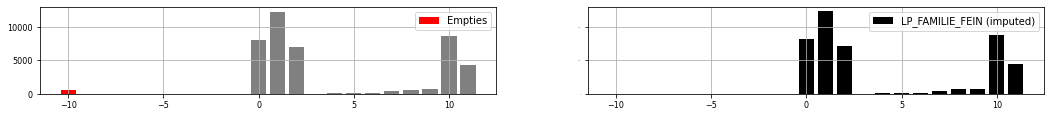

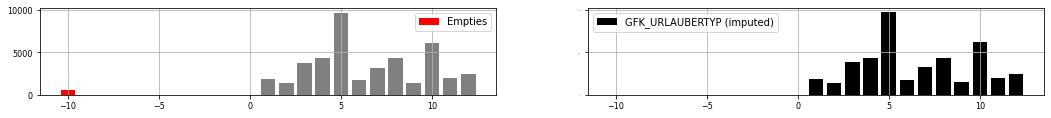

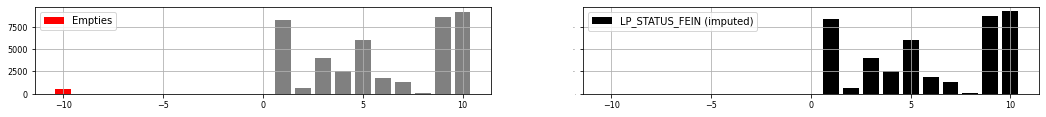

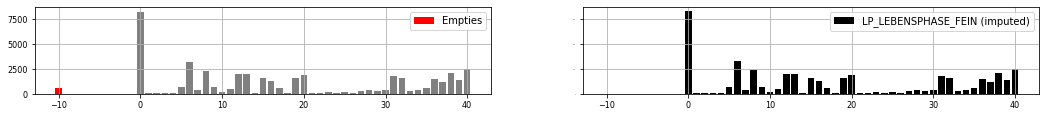

In [52]:
# Examine the rest of the missing data (Mailout Train Data), and the impact our imputing technique would have
mailed_missing = mailed[mailed.isnull().mean().sort_values(ascending=False)[mailed.isnull().mean().sort_values(ascending=False) > 0].index[:]]
mailed_missing.head()
for feature in mailed_missing:
    data_exploration.before_and_after(mailed_missing[feature], feature, nanbin=-10, height=FIG_HEIGHT/5)
    
# Examine the rest of the missing data (Mailout Test Data), and the impact our imputing technique would have
totest_missing = totest[totest.isnull().mean().sort_values(ascending=False)[totest.isnull().mean().sort_values(ascending=False) > 0].index[:]]
totest_missing.head()
for feature in totest_missing:
    data_exploration.before_and_after(totest_missing[feature], feature, nanbin=-10, height=FIG_HEIGHT/5)

The same five features required special attention: **'KBA13_ANZAHL_PKW, ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR'**, and **'EINGEZOGENAM_HH_JAHR'**

In [53]:
# Remove columns from Mailout Train missing list to prevent imputation.
mailed_missing.drop(['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR'], axis=1, inplace=True)
# Carryout imputations
for feature in mailed_missing:
    data_exploration.random_selection(mailed[feature])

In [54]:
# Remove columns from Mailout Test missing list to prevent imputation.
totest_missing.drop(['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR'], axis=1, inplace=True)
# Carryout imputations
for feature in totest_missing:
    data_exploration.random_selection(totest[feature])

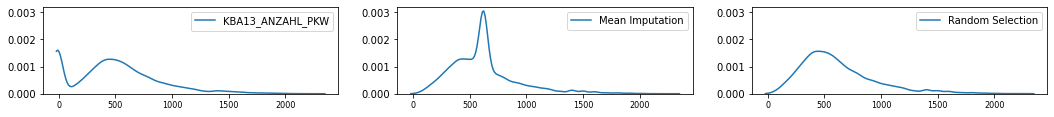

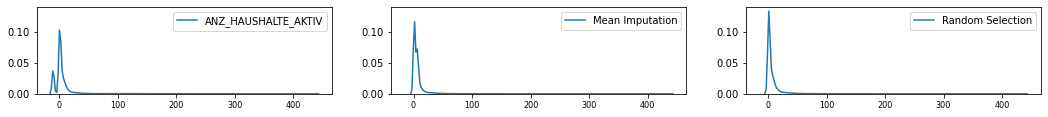

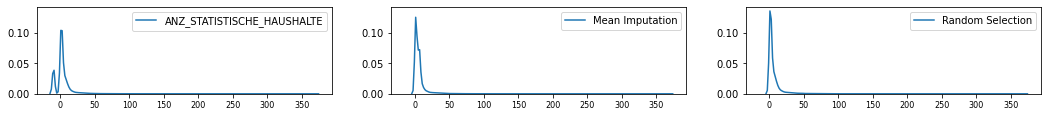

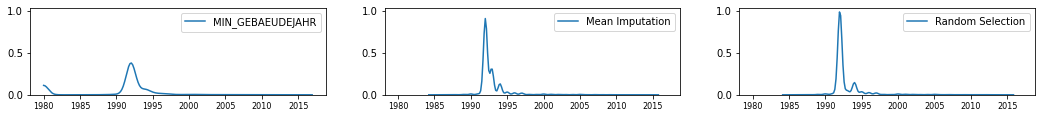

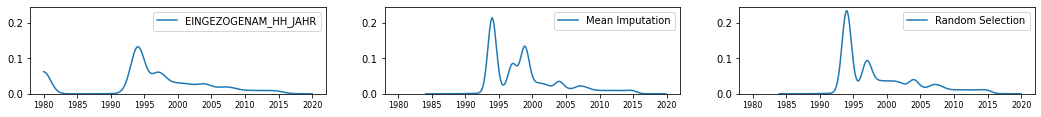

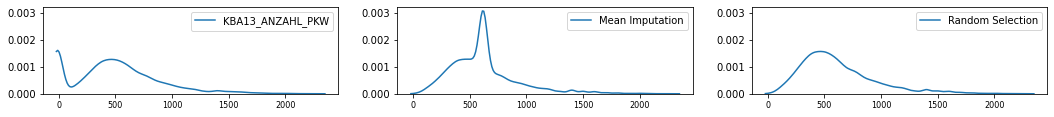

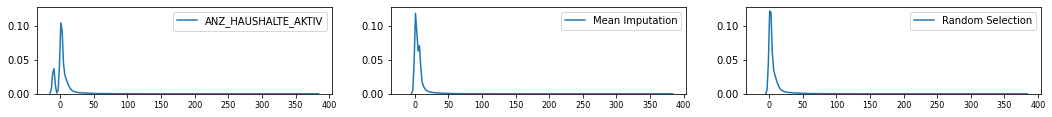

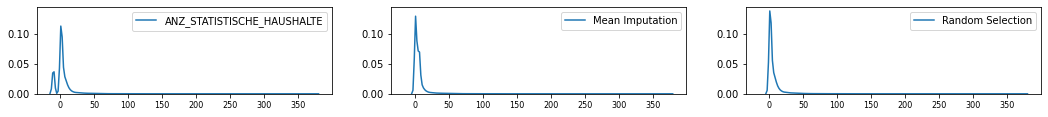

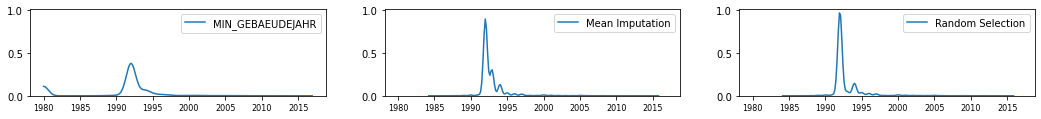

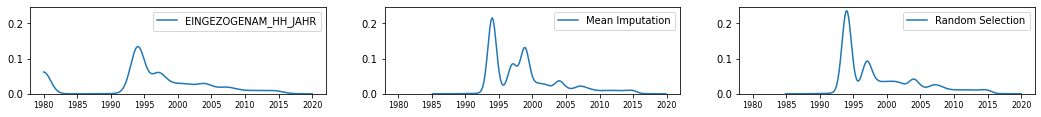

In [55]:
mo_still_missing = mailed[['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR']]
tt_still_missing = totest[['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR']]
data_exploration.mean_or_rand_sel(mailed['KBA13_ANZAHL_PKW'], 'KBA13_ANZAHL_PKW', xrange=(-20,2350),  nanbin=-10)
data_exploration.mean_or_rand_sel(mailed['ANZ_HAUSHALTE_AKTIV'], 'ANZ_HAUSHALTE_AKTIV', xrange=(-20,450),   nanbin=-10)
data_exploration.mean_or_rand_sel(mailed['ANZ_STATISTISCHE_HAUSHALTE'], 'ANZ_STATISTISCHE_HAUSHALTE', xrange=(-20,400),   nanbin=-10)
data_exploration.mean_or_rand_sel(mailed['MIN_GEBAEUDEJAHR'], 'MIN_GEBAEUDEJAHR', xrange=(1980,2020), nanbin=1980)
data_exploration.mean_or_rand_sel(mailed['EINGEZOGENAM_HH_JAHR'], 'EINGEZOGENAM_HH_JAHR', xrange=(1980,2020), nanbin=1980)
data_exploration.mean_or_rand_sel(totest['KBA13_ANZAHL_PKW'], 'KBA13_ANZAHL_PKW', xrange=(-20,2350),  nanbin=-10)
data_exploration.mean_or_rand_sel(totest['ANZ_HAUSHALTE_AKTIV'], 'ANZ_HAUSHALTE_AKTIV', xrange=(-20,400),   nanbin=-10)
data_exploration.mean_or_rand_sel(totest['ANZ_STATISTISCHE_HAUSHALTE'], 'ANZ_STATISTISCHE_HAUSHALTE', xrange=(-20,400),   nanbin=-10)
data_exploration.mean_or_rand_sel(totest['MIN_GEBAEUDEJAHR'], 'MIN_GEBAEUDEJAHR', xrange=(1980,2020), nanbin=1980)
data_exploration.mean_or_rand_sel(totest['EINGEZOGENAM_HH_JAHR'], 'EINGEZOGENAM_HH_JAHR', xrange=(1980,2020), nanbin=1980)

In [56]:
# Impute the remaining features.
for feature in mo_still_missing:
    data_exploration.random_selection(mailed[feature])
for feature in tt_still_missing:
    data_exploration.random_selection(totest[feature])

In [57]:
# Establish that no more data is missing.
print("Mailout Train missing entries: {}".format(mailed.isnull().sum().sum()))
print("Mailout Test missing entries:  {}".format(totest.isnull().sum().sum()))

Mailout Train missing entries: 0
Mailout Test missing entries:  0


In [58]:
# DROP One-Bin-takes-all categorical features D19_VERSI_ONLINE_QUOTE_12, and D19_TELKO_ONLINE_QUOTE_12
mailed.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)
totest.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)

## Handle Outliers

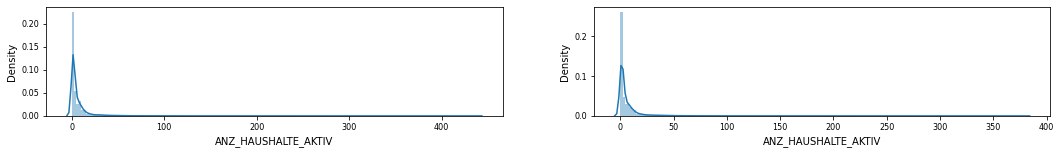

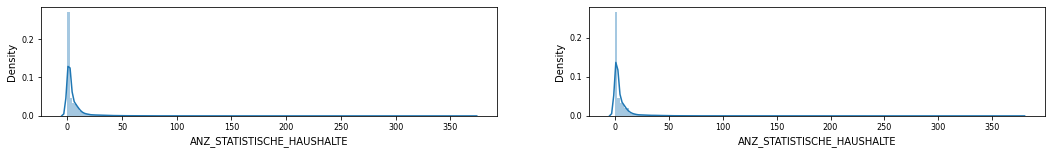

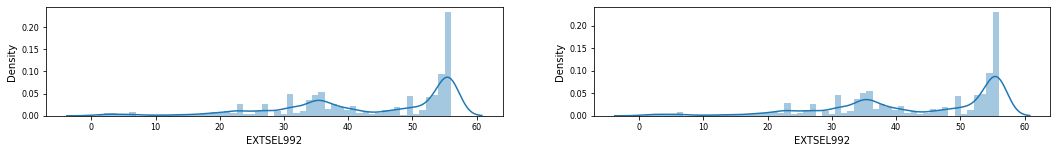

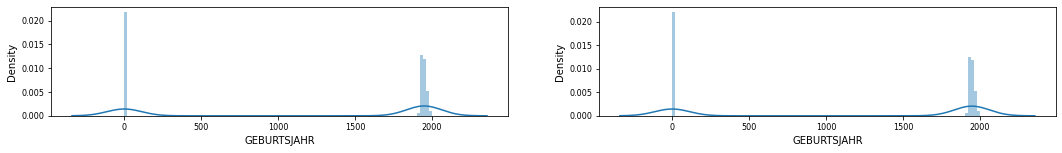

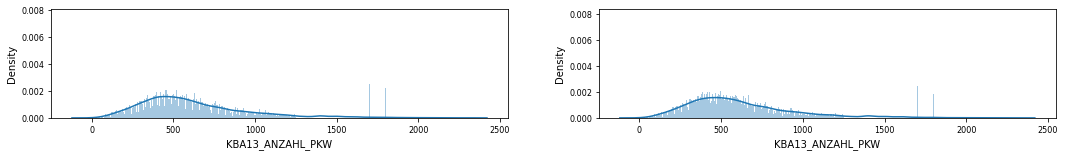

In [59]:
# Display the pseudo-numerical features for both Train and Test datasets side by side.
data_exploration.pseudo_numericals(mailed, totest)

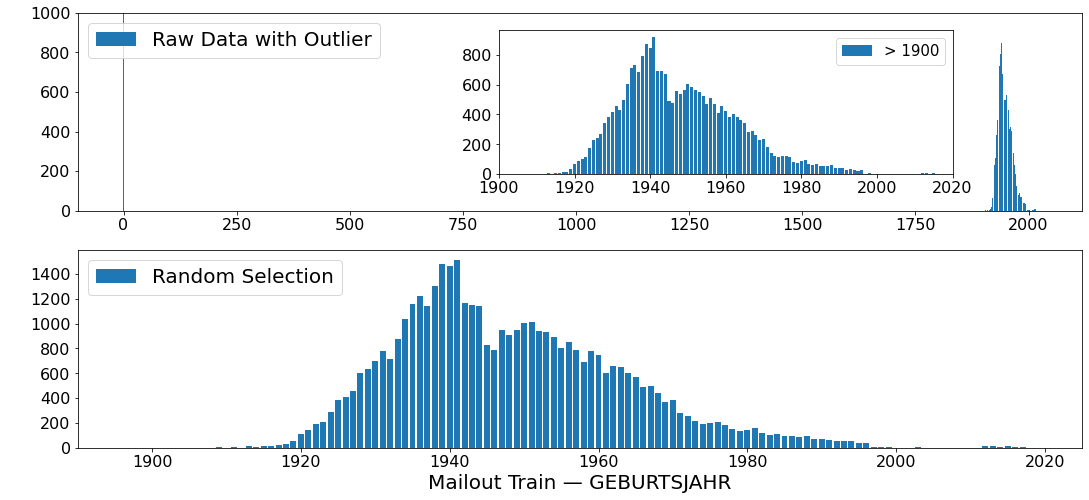

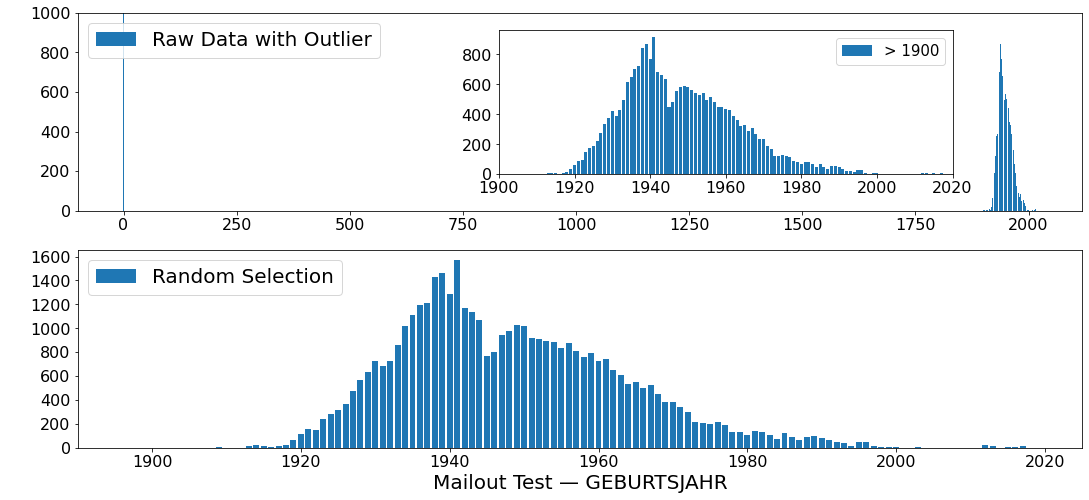

In [60]:
# Fix year zero noise in both datasets
data_exploration.anno_domini_outlier(mailed['GEBURTSJAHR'], 'Mailout Train — GEBURTSJAHR', 1000)
data_exploration.anno_domini_outlier(totest['GEBURTSJAHR'], 'Mailout Test — GEBURTSJAHR', 1000)

In [61]:
mailed['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)
mailed['KBA13_ANZAHL_PKW'].value_counts(normalize=True).sort_index(ascending=False).head(11).sum()
totest['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)
totest['KBA13_ANZAHL_PKW'].value_counts(normalize=True).sort_index(ascending=False).head(11).sum()

2300.0     36
2200.0     18
2100.0     29
2000.0     66
1900.0    108
1800.0    175
1700.0    203
1600.0    355
1500.0    472
1400.0    616
1300.0    345
1250.0     18
1249.0      8
1247.0      3
1246.0      5
Name: KBA13_ANZAHL_PKW, dtype: int64

0.05639867790140123

2300.0     18
2200.0     18
2100.0     30
2000.0     86
1900.0     63
1800.0    148
1700.0    196
1600.0    365
1500.0    428
1400.0    636
1300.0    337
1250.0      9
1249.0     10
1247.0      5
1246.0      8
Name: KBA13_ANZAHL_PKW, dtype: int64

0.054280578058973225

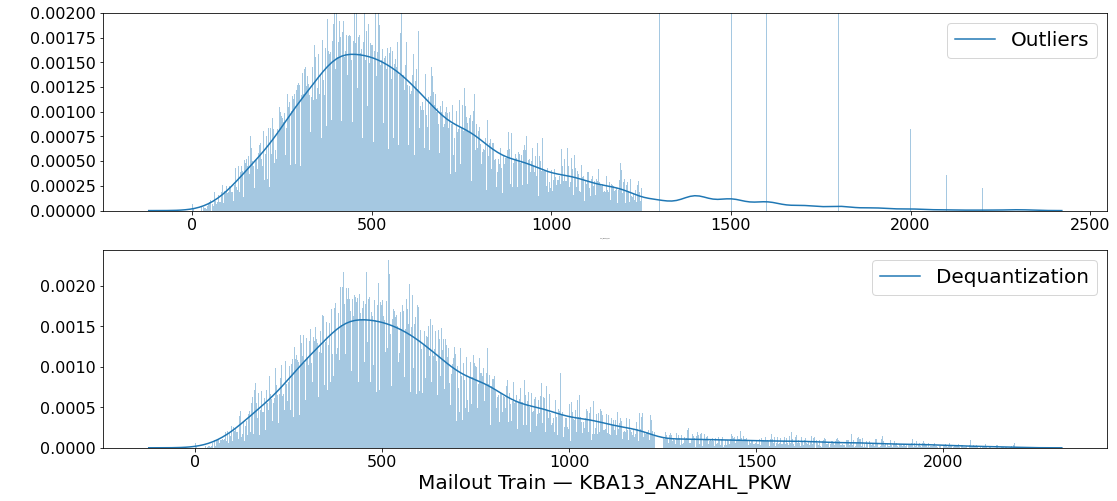

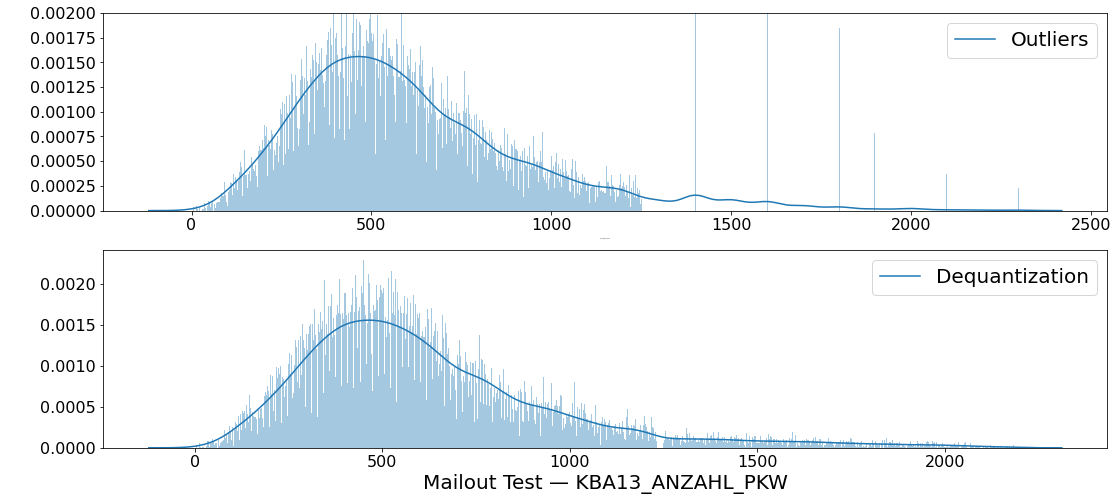

In [62]:
data_exploration.dequantize_right_tail(mailed['KBA13_ANZAHL_PKW'], 'Mailout Train — KBA13_ANZAHL_PKW')
data_exploration.dequantize_right_tail(totest['KBA13_ANZAHL_PKW'], 'Mailout Test — KBA13_ANZAHL_PKW')

<br/><br/>
## Model Selection

Supervised learning algorithms search through a hypothesis space to find a good predictor for a particular problem. We will first go through a cursory exploration of several simple models, such as Logistic Regression, as well as Ensemble techniques that generate multiple hypotheses using the same base learner like Random Forest, Adaptive Boosting, Gradient Boosting and variants like XGBoost. Boosting refers to the general idea of producing accurate predictions by combining rough and inaccurate rules-of-thumb. It is a sequential process that in some cases tends to over-fit the training data. We'll keep an eye on this during the hyperparameter tuning section with the aim of tuning our boosters in areas where no overfitting is known to occur.

Our mailout train dataset is highly imbalanced with the RESPONSE label consisting overwhelmingly of zeros, i.e., non-customers. This points us in the direction of `ROC AUC` as a performance metric for this classification problem. ROC (Receiver Operator Characteristic) is a probability curve, and AUC (Area Under the Curve) tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. This score is commonly used for comparing classification models for imbalanced problems. And for our purposes, given the nature of the problem (marketing), as well as the imbalanced quality of the labels, it will be our metric of choice. 

The code cells below explore several classifiers to get a taste of how well they perform. The best performing model will then be tuned to arrive at an optimal classification. We'll be visualizing the ROC curves and measuring the ROC AUC for each model to decide how to proceed.

In [63]:
# Split Mailout Train dataset into Train and Test subsets
from sklearn.model_selection import train_test_split
mailout_X = mailed.drop('RESPONSE', axis=1)
mailout_y = mailed['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(mailout_X, mailout_y, stratify=mailout_y, test_size=0.2, random_state=RANDOM_STATE)

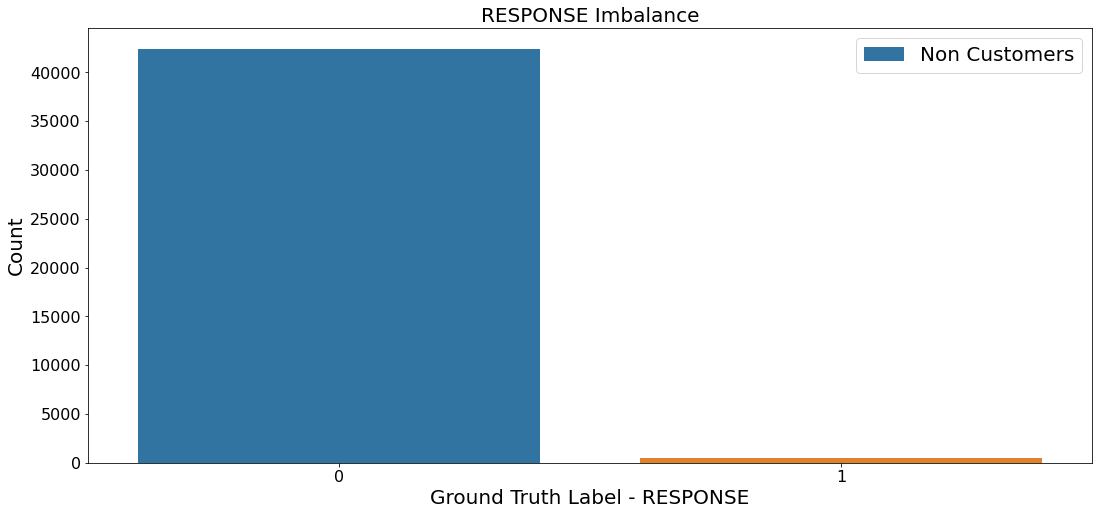

In [64]:
# Observe the imbalanced nature of the response label
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
_ = sns.countplot("RESPONSE", data=mailed)
_ = plt.title('RESPONSE Imbalance', fontsize=LABEL_SIZE)
_ = plt.xlabel("Ground Truth Label - RESPONSE", fontsize=LABEL_SIZE)
_ = plt.ylabel("Count", fontsize=20)
_ = plt.xticks(fontsize=TICKS_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.legend(["Non Customers"], fontsize=LABEL_SIZE)
_ = plt.savefig('images/Figure 11 — Mailout Data, Labels Imbalance.jpg', format='jpeg', dpi=1200, bbox_inches='tight')


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#conda install -c conda-forge xgboost
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score

<br/>**Logistic Regression:** This general classifier assumes that the outcome variable is binary, that there are no highly influential outliers that could distort the model accuracy, that there is no multicollinearity, that the observations are independent, and that the sample size is sufficiently large. Some of these assumptions are met, e.g., the binary nature of the `RESPONSE`. And some are not, e.g., multicollinearity, at least not without some processing such as principal component analysis. 

In [66]:
logistic_reg = LogisticRegression(random_state=RANDOM_STATE)
_ = logistic_reg.fit(X_train, y_train)
lr_prediction = logistic_reg.predict_proba(X_test)[:,1]
lr_roc_auc = round(100*roc_auc_score(y_test, lr_prediction),2)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prediction)

<br/>**Random Forest :** Builds multiple decision trees and merges them together to get a more accurate and stable prediction. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset.

In [67]:
rand_forest = RandomForestClassifier(random_state=RANDOM_STATE)
_ = rand_forest.fit(X_train, y_train)
rf_prediction = rand_forest.predict_proba(X_test)[:,1]
rf_roc_auc = round(100*roc_auc_score(y_test, rf_prediction),2)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prediction)

<br/>**AdaBoost :** Adaptive boosting is about training iterations that ensure the accurate predictions of unusual observations. Adaboost combines multiple “weak classifiers” and works by putting more weight on difficult to classify instances and less on those already handled well.

In [68]:
ada_boost = AdaBoostClassifier(random_state=RANDOM_STATE)
_ = ada_boost.fit(X_train, y_train)
ad_prediction = ada_boost.predict_proba(X_test)[:,1]
ad_roc_auc = round(100*roc_auc_score(y_test, ad_prediction),2)
ad_fpr, ad_tpr, _ = roc_curve(y_test, ad_prediction)

<br/>**Gradient Boost :** A generalization of the Adaptive Boosting concept where the objective is to minimize the loss of the model by adding weak learners using a gradient descent like procedure. It is a generic enough framework that any differentiable loss function can be used.

In [69]:
gradient_boost = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = gradient_boost.fit(X_train, y_train)
gb_prediction = gradient_boost.predict_proba(X_test)[:,1]
gb_roc_auc = round(100*roc_auc_score(y_test, gb_prediction),2)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_prediction)

<br/>**Extreme Gradient Boost :** XGBoost (Extreme Gradient Boosting) belongs to the family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library that is comparatively faster than other ensemble classifiers.

In [70]:
XG_boost = xgb.XGBClassifier(random_state=RANDOM_STATE)
_ = XG_boost.fit(X_train, y_train)
xg_prediction = XG_boost.predict_proba(X_test)[:,1]
xg_roc_auc = round(100*roc_auc_score(y_test, xg_prediction),2)
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_prediction)

[23:57:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


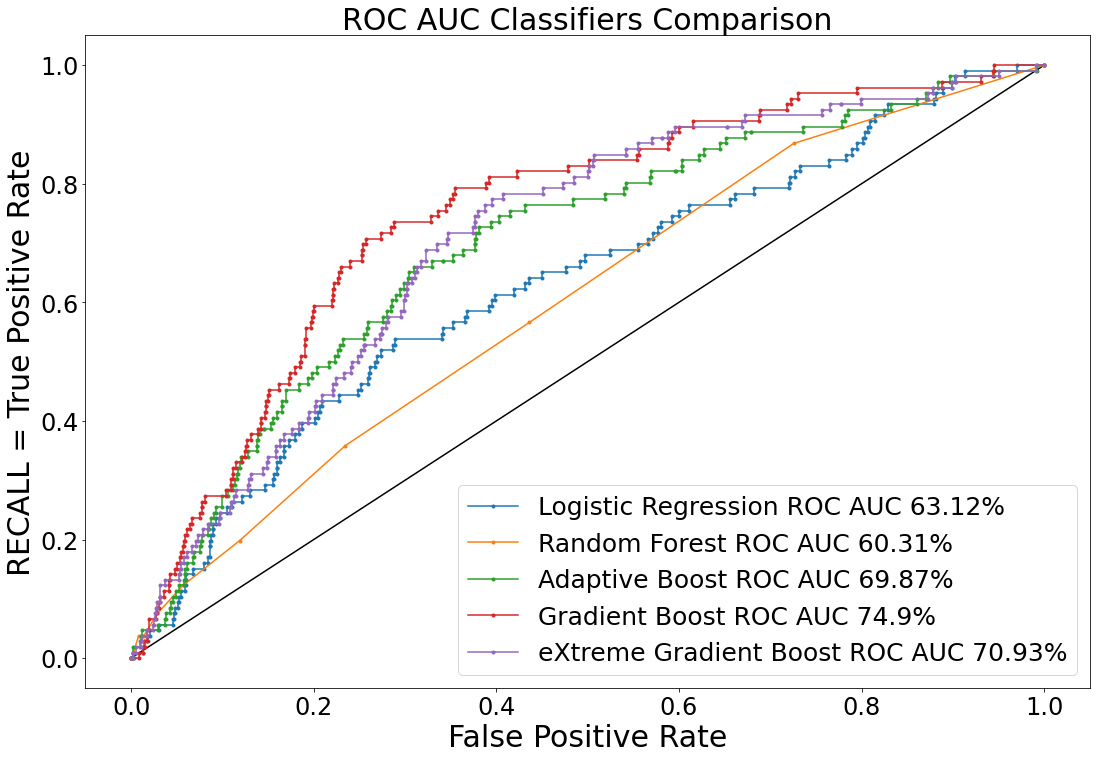

In [75]:
# Visually compare the models' ROC curves and show ROC AUC scores
f = plt.figure(figsize=(FIG_WIDTH, 3*FIG_HEIGHT/2))
_ = plt.title("ROC AUC Classifiers Comparison", fontsize=1.5*LABEL_SIZE)
_ = plt.plot([0,1], [0,1], color='black', linestyle='-')
_ = plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, lr_prediction),2)))
_ = plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, rf_prediction),2)))
_ = plt.plot(ad_fpr, ad_tpr, marker='.', label='Adaptive Boost ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, ad_prediction),2)))
_ = plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, gb_prediction),2)))
_ = plt.plot(xg_fpr, xg_tpr, marker='.', label='eXtreme Gradient Boost ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, xg_prediction),2)))
_ = plt.xlabel('False Positive Rate', fontsize=1.5*LABEL_SIZE)
_ = plt.ylabel('RECALL = True Positive Rate', fontsize=1.5*LABEL_SIZE)
_ = plt.legend(prop={'size': 25}, loc=4)
_ = plt.xticks(fontsize=1.5*TICKS_SIZE)
_ = plt.yticks(fontsize=1.5*TICKS_SIZE)
#_ = plt.savefig('images/Figure 12 — ROC Curve and ROC AUC Metric for Classifier Model Selection.jpg', format='jpeg', dpi=1200, bbox_inches='tight')


<br/><br/>
## Hyperparameter Tuning

**GradientBoostingClassifier** performed exceedingly well compared to the others, so we'll perform hyperparameter tuning on it. The overall parameters of this ensemble model can be divided into 3 categories: Tree-Specific Parameters, Boosting Parameters, and other miscellaneous parameters for overall functioning. We'll focus on a few of the most impactful tree-specific, and boosting parameters. Most GBM tuning strategies focus on the number of trees (`n_estimators`), tree depth (`max_depth`), and the learning rate (`learning_rate`). We'll tune these three parameters and explore tuning four more. The full set of parameters to tune is listed below with a brief explanation as to how they impact model learning. We'll use cross validation in tuning and the `roc_auc` metric in scoring.

- **Boosting Parameters**
    - **learning_rate:** GBM works by starting with an initial estimate which is changed using the output of each tree. The `learning_rate` parameter controls the magnitude of this change in the estimates. Lower values are generally preferred as they make the model robust to the specific characteristics of the tree, thus allowing it to generalize well.
    - **n_estimators:** The number of sequential trees to be modeled. GBM is fairly robust at higher numbers of trees but it can still overfit. Hence, this parameter should be tuned using `cross validation` for a particular learning rate. Usually a higher number of trees improves the learning.
    - **subsample:** The fraction of observations to be selected for each tree. Values slightly less than 1 make the model robust by reducing the variance.

- **Tree-specific parameters**
    - **max_depth:** This indicates how deep the tree can be. The deeper the tree, the more splits it has. Higher depth will allow the model to learn relations very specific to a particular sample (overfitting).
    - **max_features:** The number of randomly selected features to consider while searching for a best split.
    - **min_samples_split:** Defines the minimum number of samples required to split an internal node. When we increase this parameter, the tree has to consider more samples at each node, preventing the model from learning relations which might be highly specific (overfitting) to the particular sample.

The code cell below, shows us the behaviour of the model as it learns with varying values for these parameters in isolation. The learning curve graphs allow us to observe regions where the gap between the train and test results (test=red) aren't too wide (overfitting) and also not crossing (underfitting).


 learning_rate:  0.001 0.01 0.1 
 n_estimators:  10 50 100 150 
 max_depth:  2 3 4 5 
 max_features:  50 150 250 350 
 min_samples_split:  20 30 40 50 
 subsample:  0.9 0.92 0.94 0.96 0.98 

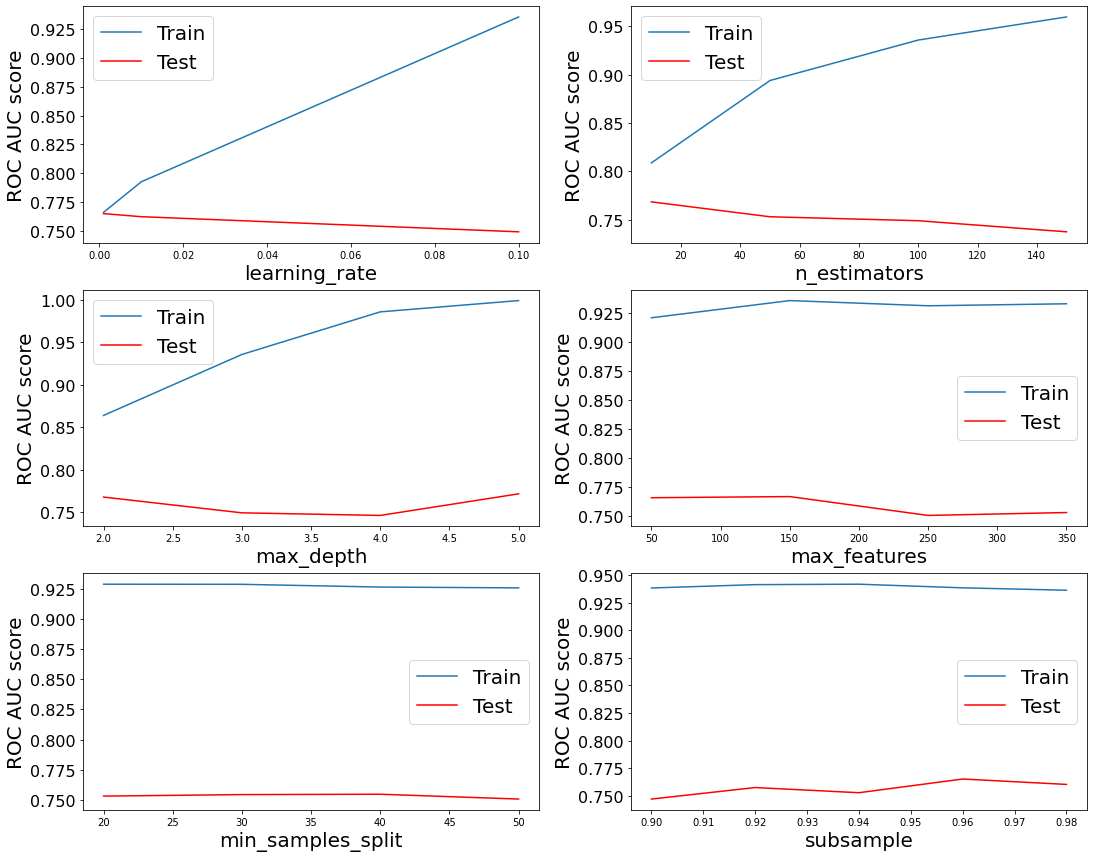

In [72]:
from sklearn.metrics import roc_curve, auc
# Observe behaviour of each parameter in isolation first, to see where the sensitive kinks are.
hyperparams = {
     "learning_rate" : [0.001, 0.01, 0.1],
     "n_estimators" : [10, 50, 100, 150],
     "max_depth" : [2, 3, 4, 5],
     "max_features" : [50, 150, 250, 350],
     "min_samples_split" : [20, 30, 40, 50],
     "subsample" : [0.9, 0.92, 0.94, 0.96, 0.98]
}
lr_train_metrics = []
lr_test_metrics = []
ne_train_metrics = []
ne_test_metrics = []
md_train_metrics = []
md_test_metrics = []
mf_train_metrics = []
mf_test_metrics = []
mss_train_metrics = []
mss_test_metrics = []
ss_train_metrics = []
ss_test_metrics = []
for hyper, values in hyperparams.items():
    print("\n " + hyper + ": ", end=' ')
    for param in values:
        print(param, end=' ')
        if hyper == "learning_rate":
            modelo = GradientBoostingClassifier( learning_rate = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            lr_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            lr_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "n_estimators":
            modelo = GradientBoostingClassifier( n_estimators = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            ne_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            ne_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "max_depth":
            modelo = GradientBoostingClassifier( max_depth = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            md_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            md_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "max_features":
            modelo = GradientBoostingClassifier( max_features = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            mf_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            mf_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "min_samples_split":
            modelo = GradientBoostingClassifier( min_samples_split = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            mss_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            mss_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "subsample":
            modelo = GradientBoostingClassifier( subsample = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            ss_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            ss_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )

f = plt.figure(figsize=(FIG_WIDTH, 2.5*FIG_HEIGHT))
ax1 = f.add_subplot(421)
_ = plt.plot(hyperparams["learning_rate"], lr_train_metrics, label='Train')
_ = plt.plot(hyperparams["learning_rate"], lr_test_metrics, label='Test', color='red')
_ = plt.ylabel('ROC AUC score', fontsize=LABEL_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.xlabel('learning_rate', fontsize=LABEL_SIZE)
_ = plt.legend(fontsize=LABEL_SIZE)
ax2 = f.add_subplot(422)
_ = plt.plot(hyperparams["n_estimators"], ne_train_metrics, label='Train')
_ = plt.plot(hyperparams["n_estimators"], ne_test_metrics, label='Test', color='red')
_ = plt.ylabel('ROC AUC score', fontsize=LABEL_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.xlabel('n_estimators', fontsize=LABEL_SIZE)
_ = plt.legend(fontsize=LABEL_SIZE)
ax3 = f.add_subplot(423)
_ = plt.plot(hyperparams["max_depth"], md_train_metrics, label='Train')
_ = plt.plot(hyperparams["max_depth"], md_test_metrics, label='Test', color='red')
_ = plt.ylabel('ROC AUC score', fontsize=LABEL_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.xlabel('max_depth', fontsize=LABEL_SIZE)
_ = plt.legend(fontsize=LABEL_SIZE)
ax4 = f.add_subplot(424)
_ = plt.plot(hyperparams["max_features"], mf_train_metrics, label='Train')
_ = plt.plot(hyperparams["max_features"], mf_test_metrics, label='Test', color='red')
_ = plt.ylabel('ROC AUC score', fontsize=LABEL_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.xlabel('max_features', fontsize=LABEL_SIZE)
_ = plt.legend(fontsize=LABEL_SIZE)
ax5 = f.add_subplot(425)
_ = plt.plot(hyperparams["min_samples_split"], mss_train_metrics, label='Train')
_ = plt.plot(hyperparams["min_samples_split"], mss_test_metrics, label='Test', color='red')
_ = plt.ylabel('ROC AUC score', fontsize=LABEL_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.xlabel('min_samples_split', fontsize=LABEL_SIZE)
_ = plt.legend(fontsize=LABEL_SIZE)
ax6 = f.add_subplot(426)
_ = plt.plot(hyperparams["subsample"], ss_train_metrics, label='Train')
_ = plt.plot(hyperparams["subsample"], ss_test_metrics, label='Test', color='red')
_ = plt.ylabel('ROC AUC score', fontsize=LABEL_SIZE)
_ = plt.yticks(fontsize=TICKS_SIZE)
_ = plt.xlabel('subsample', fontsize=LABEL_SIZE)
_ = plt.legend(fontsize=LABEL_SIZE)
_ = plt.show()


In [73]:
# Establish a baseline model and its metric
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = base_model.fit(X_train, y_train)
print("GB ROC AUC {}%".format( round(100*roc_auc_score(y_test, base_model.predict_proba(X_test)[:,1]),2)) )

GB ROC AUC 74.9%


In [79]:
# Tune four parameters
# Scoring with ROC AUC Metric, n_jobs = -1 to use all cores, Cross Validation iterations at 5
tunables = {'learning_rate':[0.001, 0.01, 0.1], 'n_estimators':[40, 50, 60],\
            'max_depth':[3, 4, 5], 'max_features':[200, 225, 250]}
tuning_model = GridSearchCV( GradientBoostingClassifier(random_state=RANDOM_STATE),\
                            tunables, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)
tuning_model.fit(X_train,y_train)
tuning_model.cv_results_
tuning_model.best_params_
print("GB ROC AUC {}%".format( round(100*tuning_model.best_score_, 2) ))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=403),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4, 5],
                         'max_features': [200, 225, 250],
                         'n_estimators': [40, 50, 60]},
             scoring='roc_auc', verbose=1)

{'mean_fit_time': array([14.73919234, 17.41934719, 19.82984262, 14.63838272, 18.90594578, 23.19929504, 16.93703065, 21.32613316, 24.79082098, 17.93296876, 22.89617987, 26.67702231, 19.68943601, 25.41399927, 30.57389994, 23.05297847, 27.65258999, 32.79759951, 22.19239588, 26.87916131, 32.47405205, 25.10924768, 31.11135426, 35.96623249, 26.72670665, 33.23124185, 39.77012973, 12.33663735, 15.3709003 , 18.49712362,
        13.89448166, 16.98114185, 20.60770512, 15.2340064 , 19.0152266 , 22.80838451, 16.60724406, 20.87726493, 24.9555006 , 18.78101611, 23.55888443, 27.94662447, 20.57858391, 25.74410892, 31.0569098 , 21.23582859, 26.34531875, 31.58838921, 23.52299361, 29.43219643, 35.47228141, 26.32102842, 33.04623017, 39.51908736, 12.29057922, 15.14449067, 18.25957646, 13.68785086, 16.98164701, 20.30757408,
        15.04623761, 18.81634636, 22.90647016, 16.71307712, 20.95381823, 24.934197  , 18.73409901, 23.38889151, 27.93732843, 20.56983595, 25.72631698, 30.81906195, 21.10404229, 26.1929112

{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 225,
 'n_estimators': 50}

GB ROC AUC 76.44%


In [ ]:
# Tune 2 more parameters
# Scoring with ROC AUC Metric, n_jobs = -1 to use all cores, Cross Validation iterations at 5
tunables = {'learning_rate':[0.001, 0.01, 0.1], 'n_estimators':[40, 50, 60],\
            'max_depth':[3, 4, 5], 'max_features':[200, 225, 250],\
            'min_samples_split':[25, 30, 35],'subsample':[0.93, 0.95, 0.97]}
tuning_model = GridSearchCV( GradientBoostingClassifier(random_state=RANDOM_STATE),\
                            tunables, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)
tuning_model.fit(X_train,y_train)
tuning_model.cv_results_
tuning_model.best_params_
print("GB ROC AUC {}%".format( round(100*tuning_model.best_score_, 2) ))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GBM ROC AUC 76.61%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



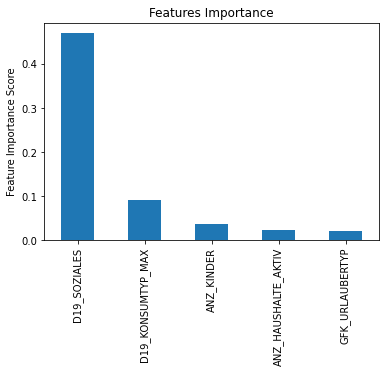

In [129]:
# Examine the most important features of the final tuned model.
final_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=50,\
                                         max_depth=4, max_features=250,\
                                         min_samples_split=30, subsample=0.95,\
                                         random_state=RANDOM_STATE)
_ = final_model.fit(X_train, y_train)
feat_imp = pd.Series(final_model.feature_importances_, list(X_train)).sort_values(ascending=False).head()
_ = feat_imp.plot(kind='bar', title='Features Importance')
_ = plt.ylabel('Feature Importance Score')
print("GBM ROC AUC {}%".format( round(100*roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]),2)) )
print(classification_report(y_test, final_model.predict(X_test)))

The plot displays the importance of the top 5 features. Further features are available by passing an argument to the `.head(X)` method above, but subsequent ones are only marginally relevant and monotonously decreasing in importance. The EXCEL spreadsheet that decrypts the names of these features is silent with respect to **D19_SOZIALES**, and **D19_KONSUMTYP_MAX**. It is hard to attach an educated guess as to why these particular features emerged in importance without access to their meaning.

In [130]:
# Prepare prediction on Test Mailout data for Kaggle scoring
preds_gb_totest = final_model.predict_proba(totest)[:,1]
kaggle_submit = pd.DataFrame(index=tt_LNR, data=preds_gb_totest)
kaggle_submit.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_submit.to_csv("HCG-Capstone_GBM_final_hypertuned.csv")

<br/><br/>
## Conclusions:

In this project we examined unsupervised as well as supervised ML techniques to identify potential customers for a targeted advertising campaign. There were a number of challenges concerning the data: First, there was a significant number of barren rows with more than 50% blank entries. More concerning, however, was the fact that the percentage of missing data was strangely structured as a ladder. Also, the EXCEL spreadsheets detailing the meaning behind the column names left a large portion of the features unexplained; this was disappointing.

After proceeding with the data preprocessing steps, namely, dropping some columns, encoding non-numerical features, imputing missing values and outliers, several visualizations were produced to inspect and compare the features' histograms of both the general population and customer datasets. What transpired was a first glance at the information we were looking for, i.e., the characterization of customers by demographic data. Briefly, we found that customers tend to be financially unremarkable shoppers of diverse products, but not online; they save and invest, but not to prepare. They are fans of nature, have high income, and have been residing (longer than 10 years) in areas of mostly 1-2 family homes, without children living at home, and are not very interested in moving. They are environmentalists, but have multiple cars in the household. They are mostly old-fashioned (traditional minded) older males from the west part of Germany, around 60 years of age, not single, top earners, with Germanic sounding names, dominant traits, critically minded, and not very social.

Using unsupervised learning techniques, we achieved a dimensionality reduction of 45% at the cost of 10% of the information. Subsequent segmentation using K-Means clustering yielded 4 segments of the population exhibiting distinctive levels of over or underrepresentation with the customers:
- Overrepresented — Wealthy Older West German Males
- Overrepresented — Money Savvy Wealthy Males
- Underrepresented — Power Couples & Retirees
- Underrepresented — Older Couples & Households

This is clearly an overgeneralization; the above customer profiles were the result of a clustering disection based on incomplete feature descriptions, and used a small fraction of PCA components per cluster, as well a reduced subset of features per PCA component. Be it as it may, it serves as a simplistic culmination of the desired outcome, i.e., the extraction of a rough customer profile by a study of the data with one ML approach.

The last part of the project consisted of a different ML approach, supervised learning. Here we selected a classifier and tuned some of its parameters using a metric appropriate for the highly imbalanced mailout campaign train and test datasets. Using ROC AUC, the Gradient Boosting Classifier was selected and a number of its boosting and tree-specific parameters were tuned. A score of 79.6% was attained in the [Kaggle Competition](https://www.kaggle.com/c/udacity-arvato-identify-customers/submissions).

As far as improvement, some ideas are: First, explore different imputation methods, particularly of the multivariate type. Second, there were a number of features, such as CAMEO_DEUINTL_2015, with bins showing inner structure. It is probably best to split these features to end up with a higher number of columns, each one possessing truly independent information. Third, the selection of four clusters was ad-hoc; here we could look into a better approach than looking for a kink on a graph by eye. Fourth, although an XGBoost algorithm was tried, we abandoned that route purely on a preliminaary untuned ROC AUC measurement — it underperformed GBM by 4% untuned; Finally, alternative tuning methods could be tried beyond the Grid Search.  

Overall, the project was fun; a lot was learned not only with regards to ML techniques, but also about the tools of the trade as applied to a real-life problem. I would recommend the course, and the project to anyone genuinely curious about Machine Learning.

<br/><br/>
## References:


- Maryuri Quintero, Aera LeBoulluec, (2018). Missing Data Imputation for Ordinal Data.
https://www.researchgate.net/publication/326435546_Missing_Data_Imputation_for_Ordinal_Data

- Lokesh, (2021). Dealing with Missing Values for Data Science Beginners. https://www.analyticsvidhya.com/blog/2021/10/guide-to-deal-with-missing-values/

- Jonathan Kropko, Ben Goodrich, Andrew Gelman & Jennifer Hill, (2013). Multiple Imputation for Continuous and Categorical Data:Comparing Joint and Conditional Approaches, page 2., http://www.stat.columbia.edu/~gelman/research/published/MI_manuscript_RR.pdf

- Chinedu Pascal Ezenkwu, Simeon Ozuomba, Constance Kalu, (2015). Application of K-Means Algorithm for Efficient Customer Segmentation: A Strategy for Targeted Customer Services; International Journal of Advanced Research in Artificial Intelligence.
https://www.researchgate.net/publication/282862569_Application_of_K-Means_Algorithm_for_Efficient_Customer_Segmentation_A_Strategy_for_Targeted_Customer_Services

- Steven M. Holland, (2019). Principal Components Analysis.
http://strata.uga.edu/software/pdf/pcaTutorial.pdf

- Trupti M. Kodinariya, Prashant R. Makwana, (2013). Review on determining number of Cluster in K-Means Clustering, International Journal of Advance Research in Computer Science and Management Studies, https://www.researchgate.net/profile/Trupti-Kodinariya/publication/313554124_Review_on_Determining_of_Cluster_in_K-means_Clustering/links/5789fda408ae59aa667931d2/Review-on-Determining-of-Cluster-in-K-means-Clustering.pdf

- Kenneth Leung, (2021). Assumptions of Logistic Regression, Clearly Explained. https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

- Niklas Donges, (2021). A Complete Guide to the Random Forest Algorithm. https://builtin.com/data-science/random-forest-algorithm

- Akash Desarda, (2019). Understanding AdaBoost. https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe

- Jason Brownlee, (2016). A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning. https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

- Manish Pathak, (2019). Using XGBoost in Python. https://www.datacamp.com/community/tutorials/xgboost-in-python

- Gradient Boosting Hyperparameters Tuning : Classifier Example
https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
